In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 2
2023-07-28 08:44:15.614767


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-16.1381)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(6.1439)
penalty_target_min tensor(-11.2791) penalty_target_max tensor(9.3598)
train_loss:  -8.267597317886352
valid_loss:  -7.576694818115234
h_min_tilde -11.2791395 ell_tilde -8.129416817932128 kappa_tilde 0.0005634609715193708


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 2.384185791015625e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.7217559814453125

 2 3.5897700786590576

 3 3.2439520359039307

 4 4.447903633117676

 5 4.754493236541748

 6 3.972280502319336

 7 6.634313106536865

 8 7.053190469741821

 9 3.9898436069488525

 10 3.249851703643799

 11 3.4647226333618164

 12 3.4377083778381348

 13 3.3963582515716553

 14 3.394099473953247

 15 3.412372350692749

 16 3.6457810401916504

 17 3.4273271560668945

 18 3.4671037197113037

 19 3.409381151199341

 20 3.241154909133911

 21 3.3553552627563477

 22 6.572979927062988

 23 5.667978286743164

 24 3.488022804260254

 25 3.2366182804107666

 26 3.2272019386291504

 27 3.3276922702789307

 28 6.805528163909912

 29 7.357536792755127

 30 6.863035440444946

 31 6.933484792709351

 32 5.31490159034729

 33 6.676317453384399

 34 7.028576612472534

 35 6.816887855529785

 36 6.870589256286621

 37 6.818068027496338

 38 4.254670858383179

 39 5.327013731002808

 40 7.046187400817871

 41 3.9255716800689697

 42 3.433685302734375

 43 3.673022508621216

 44 3

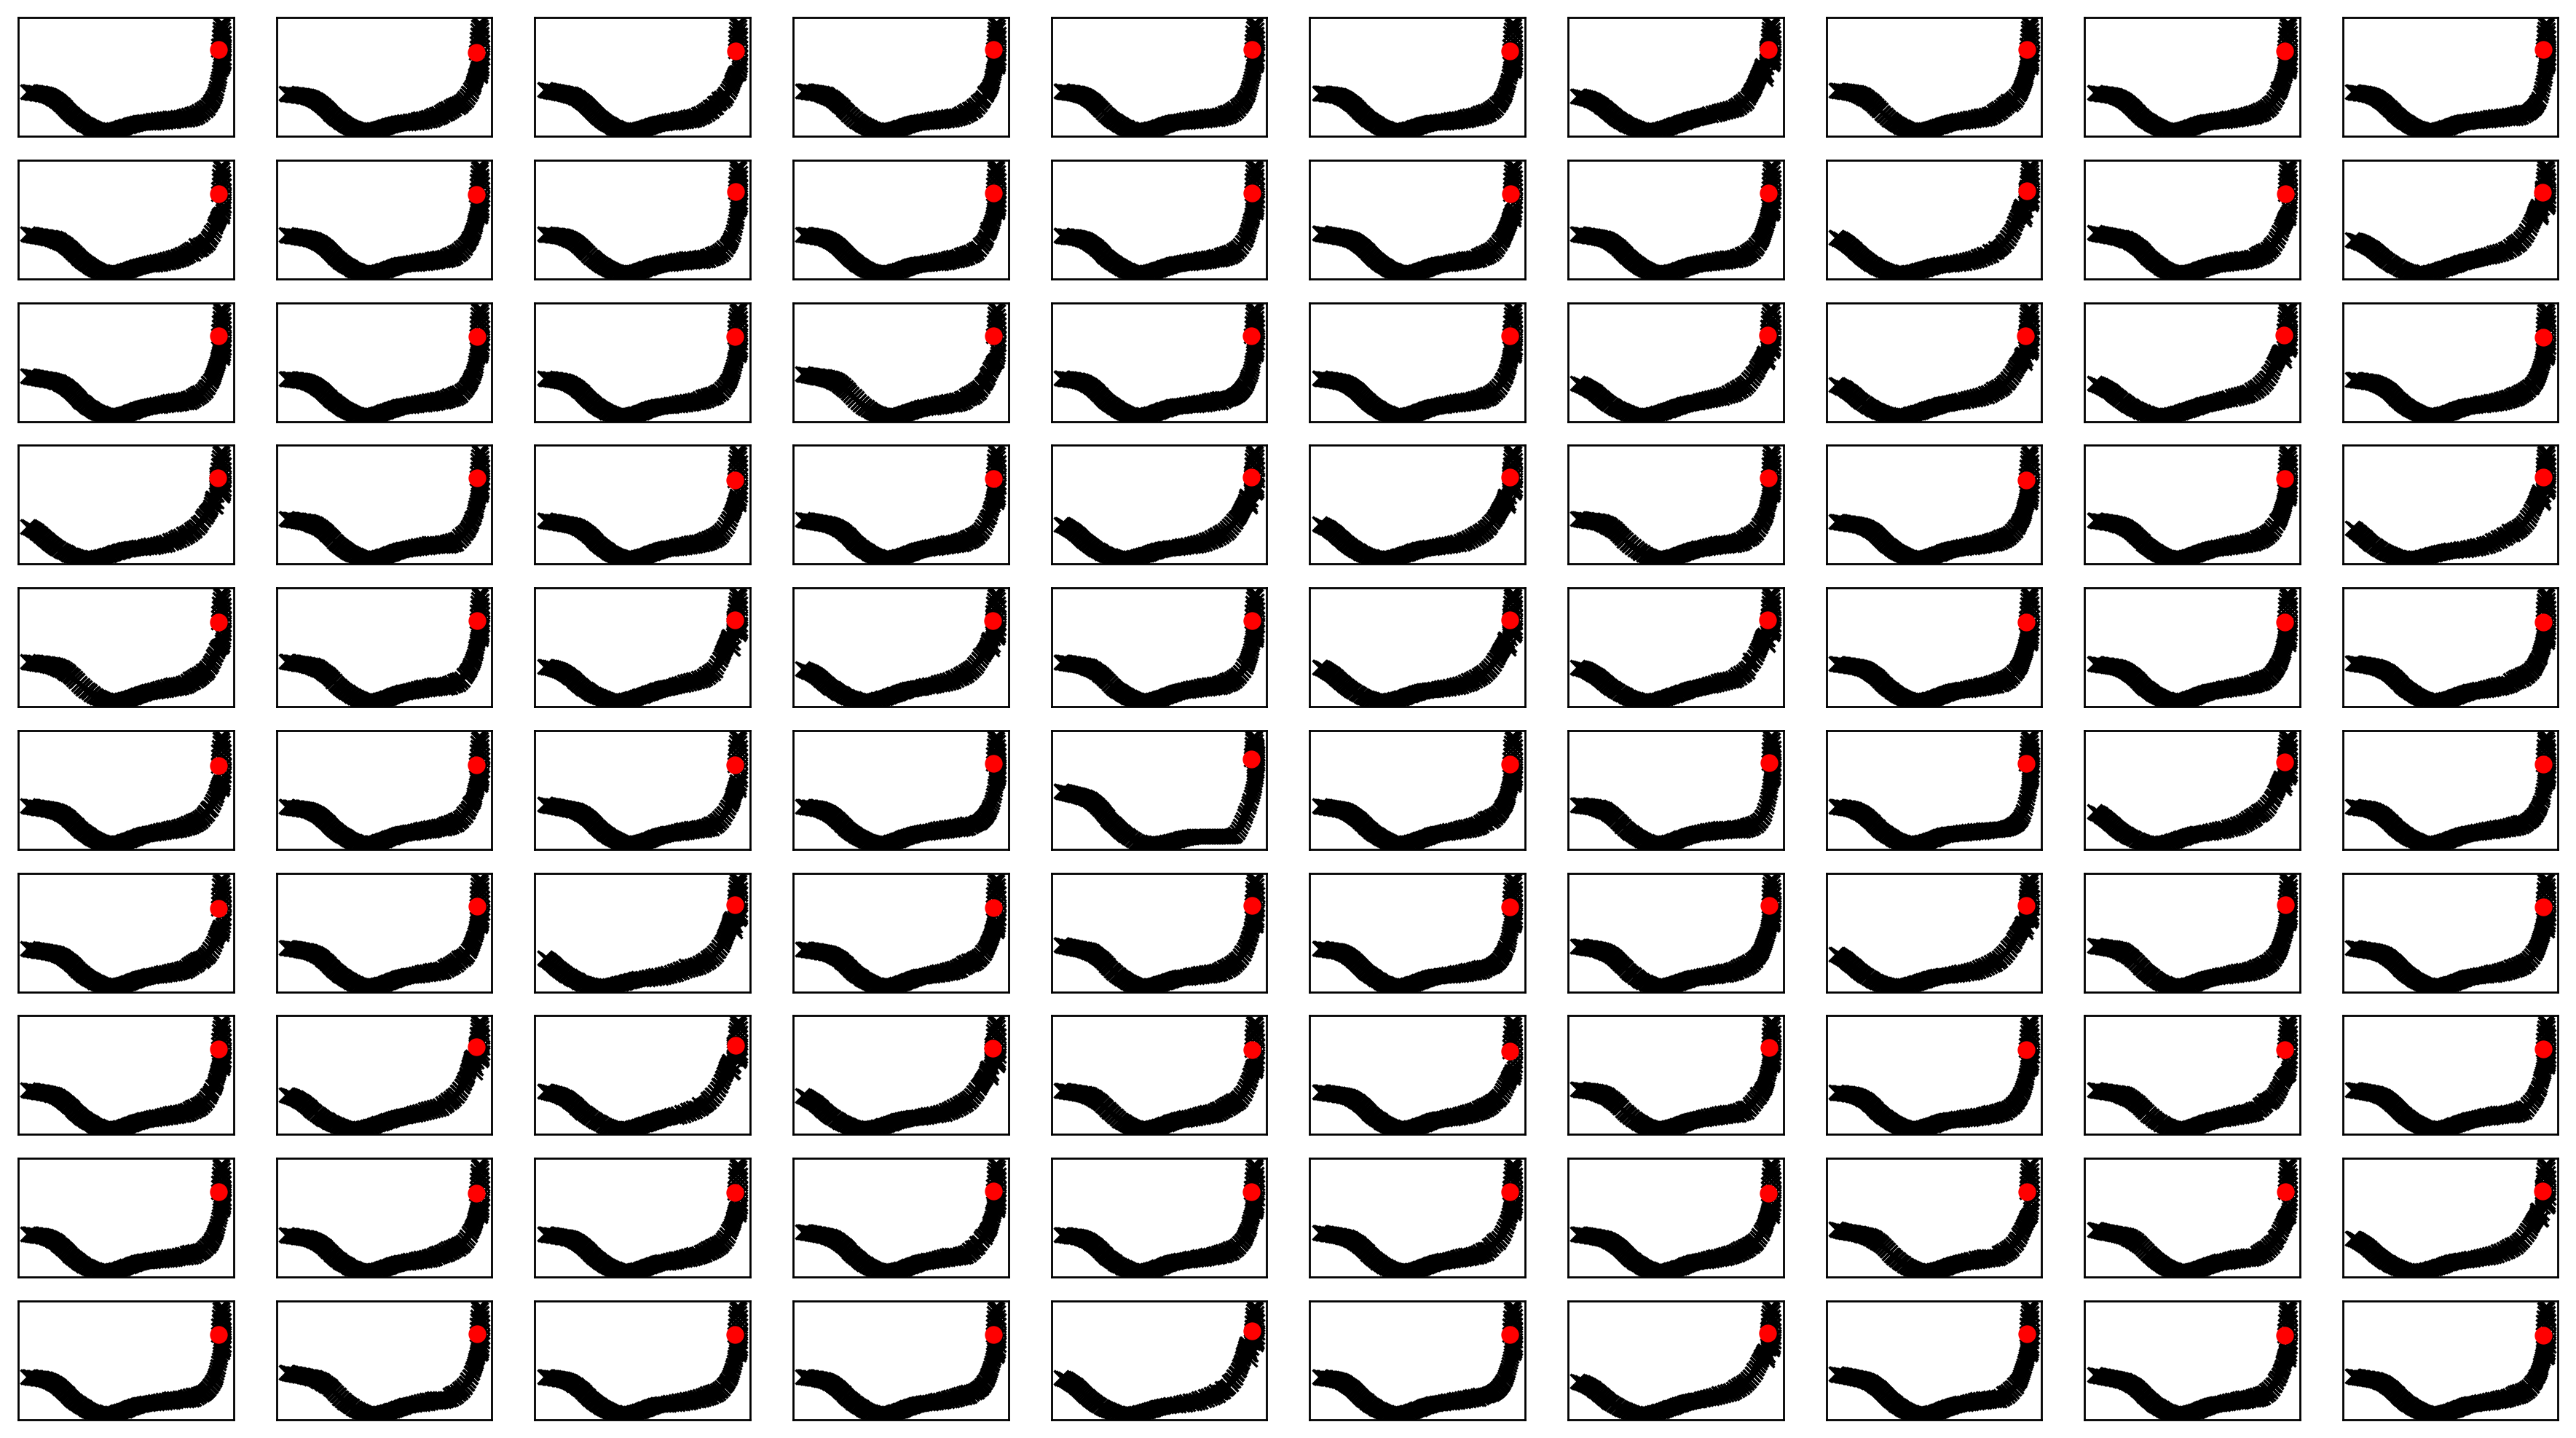

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

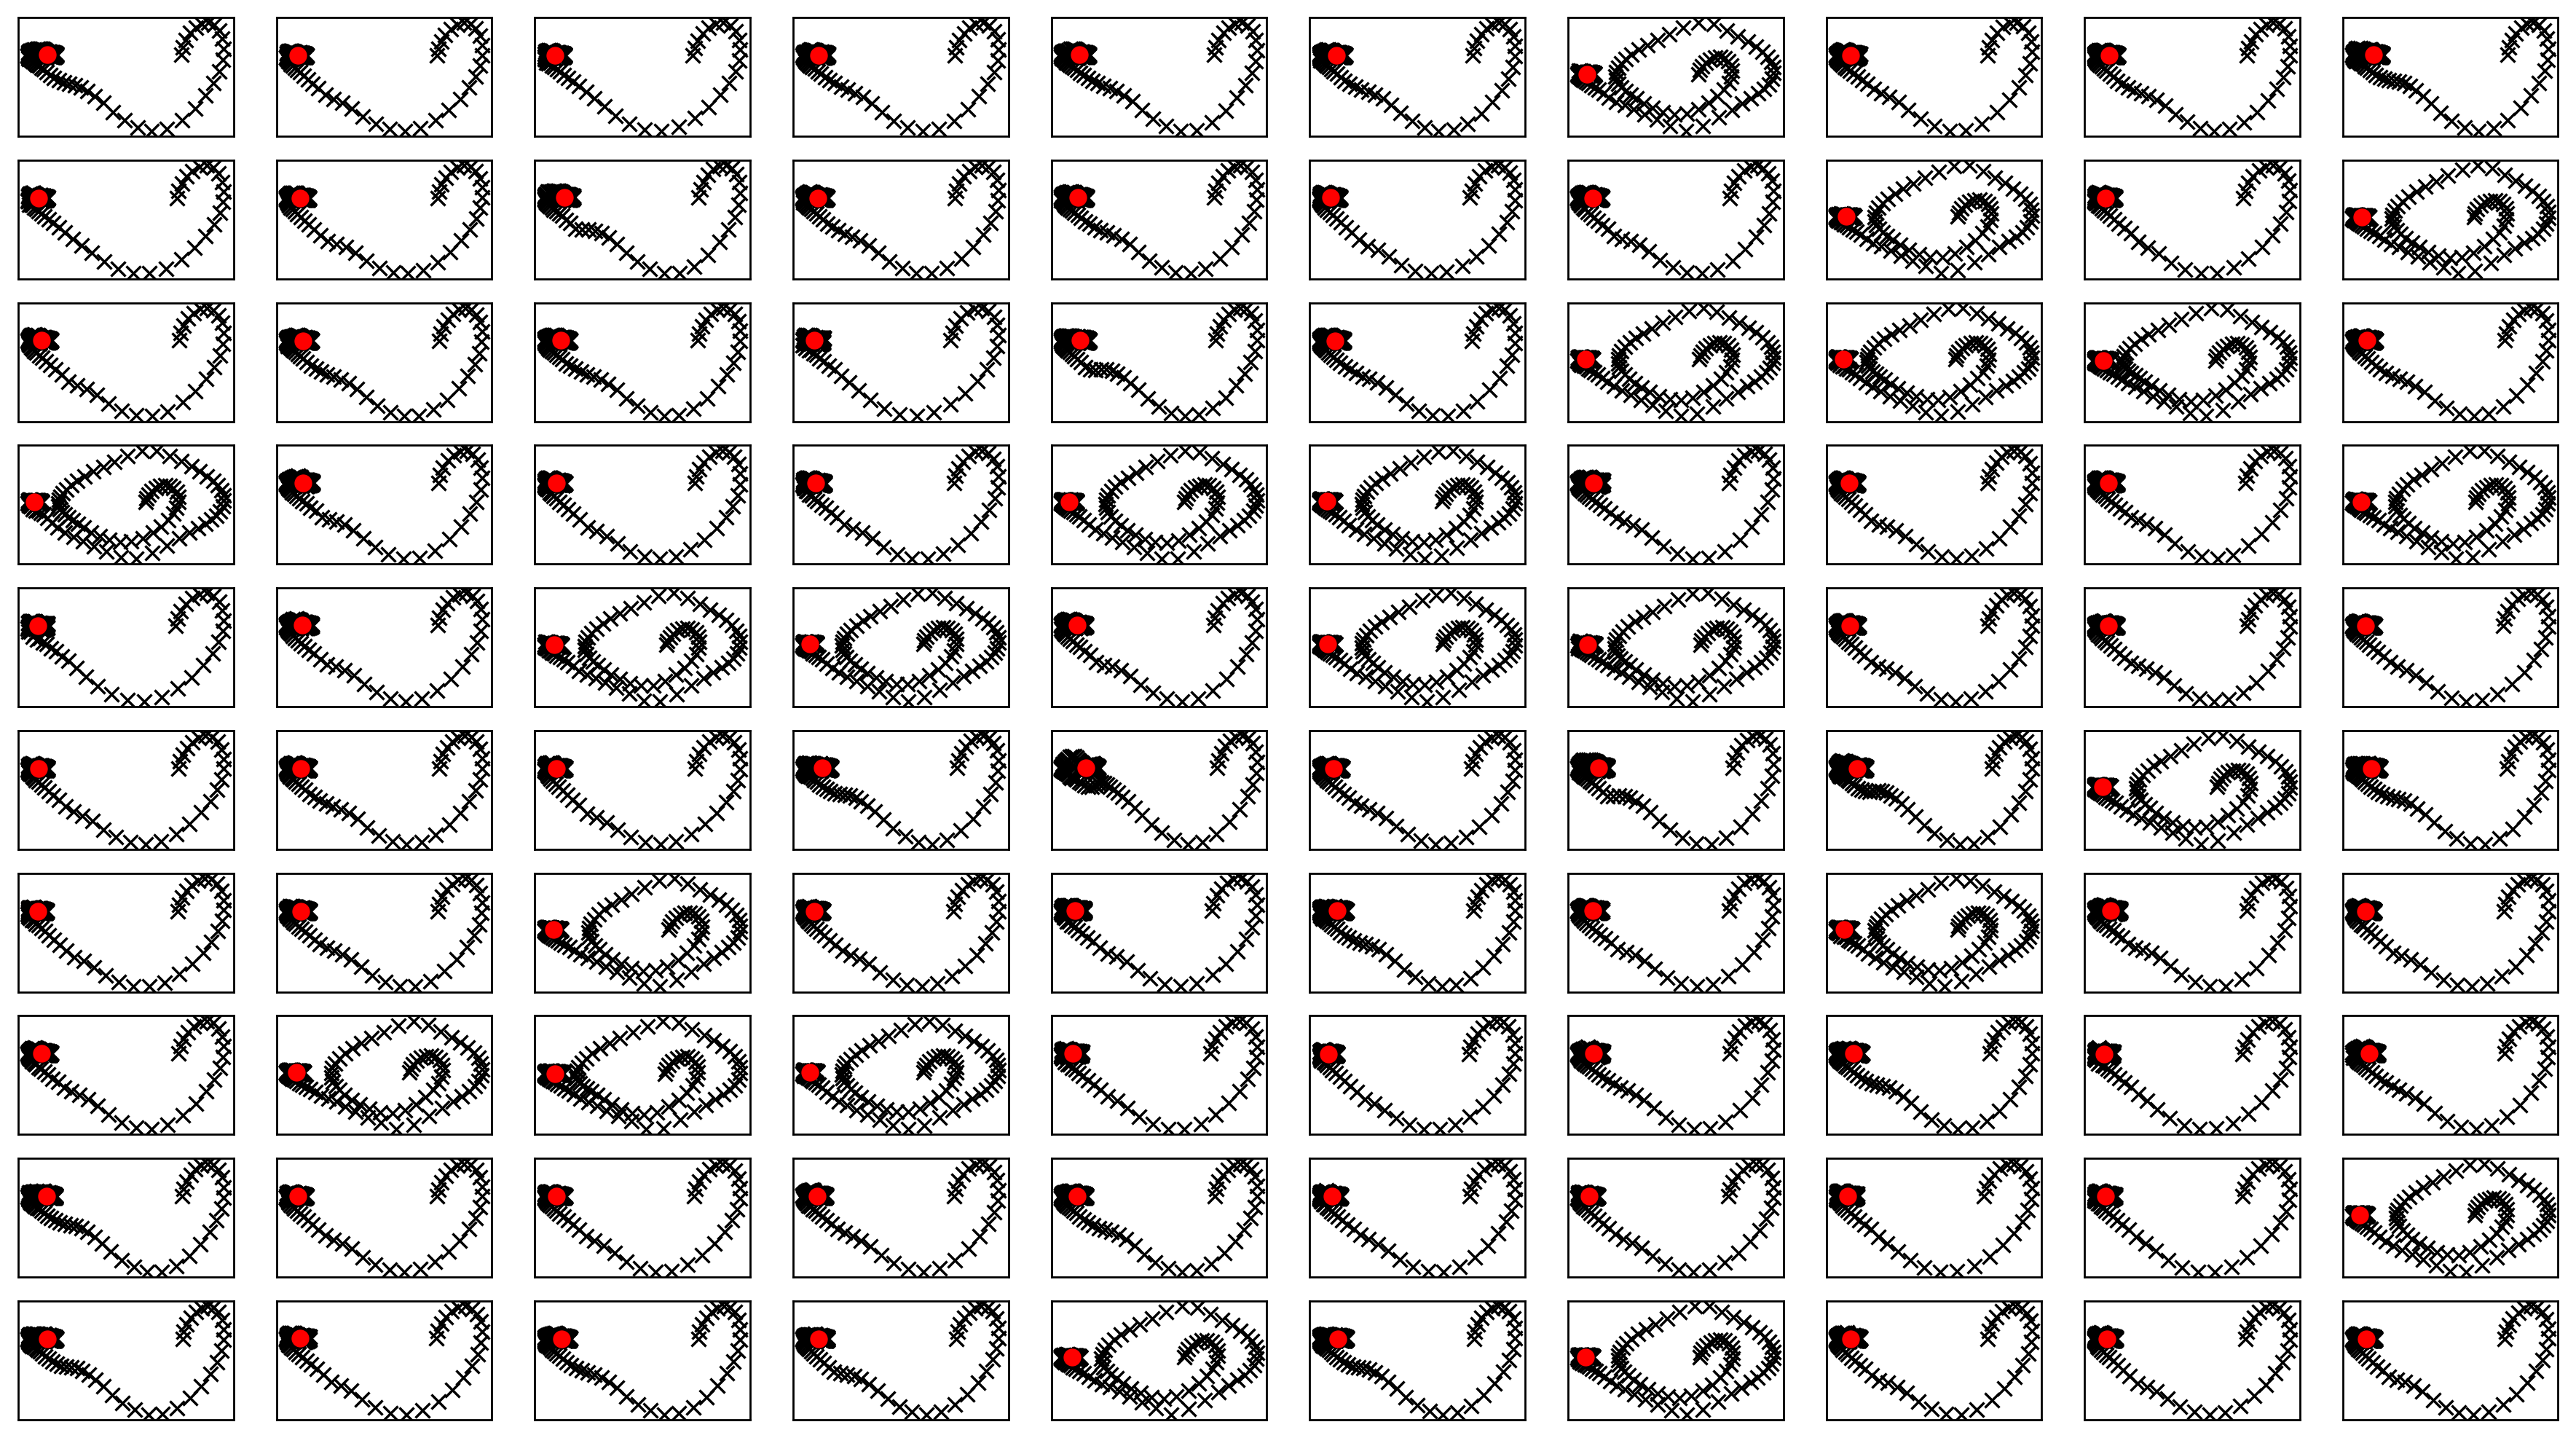

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-28 08:51:14.574853


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.32330  validloss 1.41705±0.00000  bestvalidloss 1.41705  last_update 0
train: iter 1  trainloss 1.19739  validloss 1.19783±0.00000  bestvalidloss 1.19783  last_update 0
train: iter 2  trainloss 1.14092  validloss 1.08929±0.00000  bestvalidloss 1.08929  last_update 0
train: iter 3  trainloss 1.09140  validloss 1.02168±0.00000  bestvalidloss 1.02168  last_update 0
train: iter 4  trainloss 1.03616  validloss 0.95134±0.00000  bestvalidloss 0.95134  last_update 0
train: iter 5  trainloss 0.97286  validloss 0.87782±0.00000  bestvalidloss 0.87782  last_update 0
train: iter 6  trainloss 0.91395  validloss 0.80944±0.00000  bestvalidloss 0.80944  last_update 0
train: iter 7  trainloss 0.85286  validloss 0.72613±0.00000  bestvalidloss 0.72613  last_update 0
train: iter 8  trainloss 0.79643  validloss 0.66780±0.00000  bestvalidloss 0.66780  last_update 0
train: iter 9  trainloss 0.75264  validloss 0.62794±0.00000  bestvalidloss 0.62794  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.45208  validloss 0.46045±0.00000  bestvalidloss 0.41558  last_update 5
train: iter 84  trainloss 0.44550  validloss 0.42279±0.00000  bestvalidloss 0.41558  last_update 6
train: iter 85  trainloss 0.44485  validloss 0.42279±0.00000  bestvalidloss 0.41558  last_update 7
train: iter 86  trainloss 0.43867  validloss 0.43212±0.00000  bestvalidloss 0.41558  last_update 8
train: iter 87  trainloss 0.44240  validloss 0.41691±0.00000  bestvalidloss 0.41558  last_update 9
train: iter 88  trainloss 0.44151  validloss 0.43178±0.00000  bestvalidloss 0.41558  last_update 10
train: iter 89  trainloss 0.44121  validloss 0.43250±0.00000  bestvalidloss 0.41558  last_update 11
train: iter 90  trainloss 0.43781  validloss 0.41541±0.00000  bestvalidloss 0.41541  last_update 0
train: iter 91  trainloss 0.43996  validloss 0.42315±0.00000  bestvalidloss 0.41541  last_update 1
train: iter 92  trainloss 0.44936  validloss 0.40675±0.00000  bestvalidloss 0.40675  last_update 0
train: i

train: iter 166  trainloss 0.40677  validloss 0.37646±0.00000  bestvalidloss 0.37389  last_update 2
train: iter 167  trainloss 0.40495  validloss 0.39096±0.00000  bestvalidloss 0.37389  last_update 3
train: iter 168  trainloss 0.39887  validloss 0.37577±0.00000  bestvalidloss 0.37389  last_update 4
train: iter 169  trainloss 0.39804  validloss 0.38052±0.00000  bestvalidloss 0.37389  last_update 5
train: iter 170  trainloss 0.40135  validloss 0.37599±0.00000  bestvalidloss 0.37389  last_update 6
train: iter 171  trainloss 0.39387  validloss 0.37286±0.00000  bestvalidloss 0.37286  last_update 0
train: iter 172  trainloss 0.39983  validloss 0.38657±0.00000  bestvalidloss 0.37286  last_update 1
train: iter 173  trainloss 0.40077  validloss 0.39128±0.00000  bestvalidloss 0.37286  last_update 2
train: iter 174  trainloss 0.39390  validloss 0.37984±0.00000  bestvalidloss 0.37286  last_update 3
train: iter 175  trainloss 0.39454  validloss 0.37078±0.00000  bestvalidloss 0.37078  last_update 0


train: iter 248  trainloss 0.36739  validloss 0.35139±0.00000  bestvalidloss 0.34212  last_update 8
train: iter 249  trainloss 0.36296  validloss 0.34486±0.00000  bestvalidloss 0.34212  last_update 9
train: iter 250  trainloss 0.36988  validloss 0.33511±0.00000  bestvalidloss 0.33511  last_update 0
train: iter 251  trainloss 0.35774  validloss 0.34002±0.00000  bestvalidloss 0.33511  last_update 1
train: iter 252  trainloss 0.36157  validloss 0.37403±0.00000  bestvalidloss 0.33511  last_update 2
train: iter 253  trainloss 0.36433  validloss 0.34297±0.00000  bestvalidloss 0.33511  last_update 3
train: iter 254  trainloss 0.36655  validloss 0.34331±0.00000  bestvalidloss 0.33511  last_update 4
train: iter 255  trainloss 0.36344  validloss 0.34752±0.00000  bestvalidloss 0.33511  last_update 5
train: iter 256  trainloss 0.36341  validloss 0.35126±0.00000  bestvalidloss 0.33511  last_update 6
train: iter 257  trainloss 0.36763  validloss 0.35546±0.00000  bestvalidloss 0.33511  last_update 7


train: iter 330  trainloss 0.34104  validloss 0.32686±0.00000  bestvalidloss 0.31704  last_update 8
train: iter 331  trainloss 0.33577  validloss 0.33038±0.00000  bestvalidloss 0.31704  last_update 9
train: iter 332  trainloss 0.33722  validloss 0.32366±0.00000  bestvalidloss 0.31704  last_update 10
train: iter 333  trainloss 0.34094  validloss 0.33285±0.00000  bestvalidloss 0.31704  last_update 11
train: iter 334  trainloss 0.33507  validloss 0.32274±0.00000  bestvalidloss 0.31704  last_update 12
train: iter 335  trainloss 0.33951  validloss 0.32033±0.00000  bestvalidloss 0.31704  last_update 13
train: iter 336  trainloss 0.33840  validloss 0.32038±0.00000  bestvalidloss 0.31704  last_update 14
train: iter 337  trainloss 0.33793  validloss 0.31910±0.00000  bestvalidloss 0.31704  last_update 15
train: iter 338  trainloss 0.34346  validloss 0.33141±0.00000  bestvalidloss 0.31704  last_update 16
train: iter 339  trainloss 0.33712  validloss 0.31414±0.00000  bestvalidloss 0.31414  last_up

train: iter 412  trainloss 0.32797  validloss 0.31857±0.00000  bestvalidloss 0.30665  last_update 24
train: iter 413  trainloss 0.31989  validloss 0.31848±0.00000  bestvalidloss 0.30665  last_update 25
train: iter 414  trainloss 0.32628  validloss 0.31053±0.00000  bestvalidloss 0.30665  last_update 26
train: iter 415  trainloss 0.32241  validloss 0.31490±0.00000  bestvalidloss 0.30665  last_update 27
train: iter 416  trainloss 0.32338  validloss 0.31882±0.00000  bestvalidloss 0.30665  last_update 28
train: iter 417  trainloss 0.33002  validloss 0.31621±0.00000  bestvalidloss 0.30665  last_update 29
train: iter 418  trainloss 0.31751  validloss 0.33569±0.00000  bestvalidloss 0.30665  last_update 30
train: iter 419  trainloss 0.32558  validloss 0.31893±0.00000  bestvalidloss 0.30665  last_update 31
train: iter 420  trainloss 0.32003  validloss 0.30990±0.00000  bestvalidloss 0.30665  last_update 32
train: iter 421  trainloss 0.32285  validloss 0.31814±0.00000  bestvalidloss 0.30665  last_

train_loss:  -3.2334680550962687
valid_loss:  -3.7789145891666407
weight_alpha 1.0 h_min_tilde -11.2791395 ell_tilde -3.3425573619103432 kappa_tilde 0.00035496312722482445
train_loss:  -4.23627083954811
valid_loss:  -3.581538502120972
weight_alpha 0.1 h_min_tilde -11.2791395 ell_tilde -4.105324372062683 kappa_tilde 0.0003733575251959001


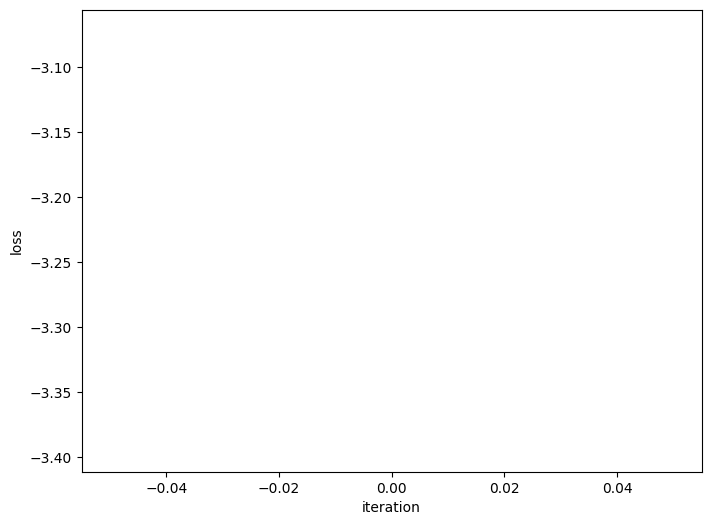

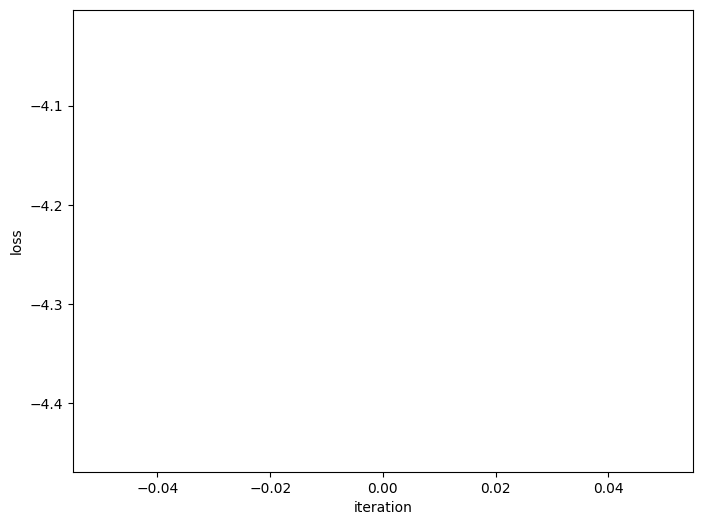

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -821.36819  validloss -716.50930±0.00000  bestvalidloss -716.50930  last_update 0
train: iter 1  trainloss -824.89458  validloss -626.07198±0.00000  bestvalidloss -716.50930  last_update 1
train: iter 2  trainloss -832.25847  validloss -699.39168±0.00000  bestvalidloss -716.50930  last_update 2
train: iter 3  trainloss -827.71992  validloss -673.11195±0.00000  bestvalidloss -716.50930  last_update 3
train: iter 4  trainloss -814.68330  validloss -696.74328±0.00000  bestvalidloss -716.50930  last_update 4
train: iter 5  trainloss -836.67269  validloss -705.47026±0.00000  bestvalidloss -716.50930  last_update 5
train: iter 6  trainloss -836.89547  validloss -699.41937±0.00000  bestvalidloss -716.50930  last_update 6
train: iter 7  trainloss -827.25238  validloss -696.39976±0.00000  bestvalidloss -716.50930  last_update 7
train: iter 8  trainloss -835.45445  validloss -699.94592±0.00000  bestvalidloss -716.50930  last_u

train: iter 75  trainloss -832.15278  validloss -678.54108±0.00000  bestvalidloss -716.50930  last_update 75
train: iter 76  trainloss -833.45182  validloss -673.22508±0.00000  bestvalidloss -716.50930  last_update 76
train: iter 77  trainloss -819.05081  validloss -668.56886±0.00000  bestvalidloss -716.50930  last_update 77
train: iter 78  trainloss -826.17395  validloss -691.40978±0.00000  bestvalidloss -716.50930  last_update 78
train: iter 79  trainloss -832.91090  validloss -679.82261±0.00000  bestvalidloss -716.50930  last_update 79
train: iter 80  trainloss -807.26806  validloss -688.93515±0.00000  bestvalidloss -716.50930  last_update 80
train: iter 81  trainloss -803.27525  validloss -559.94968±0.00000  bestvalidloss -716.50930  last_update 81
train: iter 82  trainloss -828.11982  validloss -678.68517±0.00000  bestvalidloss -716.50930  last_update 82
train: iter 83  trainloss -798.84773  validloss -679.10229±0.00000  bestvalidloss -716.50930  last_update 83
train: iter 84  tra

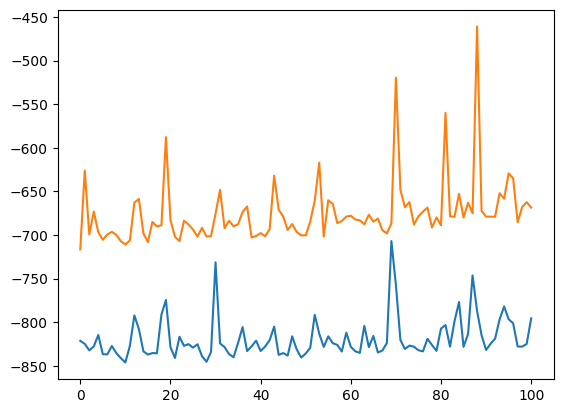

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-28 09:44:41.068959


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.39856  validloss 0.44595±0.00000  bestvalidloss 0.44595  last_update 0
train: iter 1  trainloss 0.39058  validloss 0.34621±0.00000  bestvalidloss 0.34621  last_update 0
train: iter 2  trainloss 0.36970  validloss 0.35102±0.00000  bestvalidloss 0.34621  last_update 1
train: iter 3  trainloss 0.36729  validloss 0.34162±0.00000  bestvalidloss 0.34162  last_update 0
train: iter 4  trainloss 0.36746  validloss 0.36508±0.00000  bestvalidloss 0.34162  last_update 1
train: iter 5  trainloss 0.36555  validloss 0.35075±0.00000  bestvalidloss 0.34162  last_update 2
train: iter 6  trainloss 0.36881  validloss 0.33769±0.00000  bestvalidloss 0.33769  last_update 0
train: iter 7  trainloss 0.37397  validloss 0.35097±0.00000  bestvalidloss 0.33769  last_update 1
train: iter 8  trainloss 0.36275  validloss 0.33805±0.00000  bestvalidloss 0.33769  last_update 2
train: iter 9  trainloss 0.35775  validloss 0.35390±0.00000  bestvalidloss 0.33769  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.33187  validloss 0.34029±0.00000  bestvalidloss 0.32567  last_update 5
train: iter 84  trainloss 0.33233  validloss 0.32637±0.00000  bestvalidloss 0.32567  last_update 6
train: iter 85  trainloss 0.33659  validloss 0.32424±0.00000  bestvalidloss 0.32424  last_update 0
train: iter 86  trainloss 0.33614  validloss 0.35227±0.00000  bestvalidloss 0.32424  last_update 1
train: iter 87  trainloss 0.33479  validloss 0.32593±0.00000  bestvalidloss 0.32424  last_update 2
train: iter 88  trainloss 0.33462  validloss 0.33363±0.00000  bestvalidloss 0.32424  last_update 3
train: iter 89  trainloss 0.33214  validloss 0.32988±0.00000  bestvalidloss 0.32424  last_update 4
train: iter 90  trainloss 0.33076  validloss 0.32621±0.00000  bestvalidloss 0.32424  last_update 5
train: iter 91  trainloss 0.33453  validloss 0.33894±0.00000  bestvalidloss 0.32424  last_update 6
train: iter 92  trainloss 0.33271  validloss 0.33508±0.00000  bestvalidloss 0.32424  last_update 7
train: ite

train: iter 165  trainloss 0.32366  validloss 0.31507±0.00000  bestvalidloss 0.31129  last_update 13
train: iter 166  trainloss 0.31791  validloss 0.32680±0.00000  bestvalidloss 0.31129  last_update 14
train: iter 167  trainloss 0.32044  validloss 0.32946±0.00000  bestvalidloss 0.31129  last_update 15
train: iter 168  trainloss 0.32346  validloss 0.32015±0.00000  bestvalidloss 0.31129  last_update 16
train: iter 169  trainloss 0.31675  validloss 0.32126±0.00000  bestvalidloss 0.31129  last_update 17
train: iter 170  trainloss 0.31877  validloss 0.32382±0.00000  bestvalidloss 0.31129  last_update 18
train: iter 171  trainloss 0.31539  validloss 0.31904±0.00000  bestvalidloss 0.31129  last_update 19
train: iter 172  trainloss 0.32240  validloss 0.34641±0.00000  bestvalidloss 0.31129  last_update 20
train: iter 173  trainloss 0.31703  validloss 0.33456±0.00000  bestvalidloss 0.31129  last_update 21
train: iter 174  trainloss 0.31740  validloss 0.31327±0.00000  bestvalidloss 0.31129  last_

train: iter 247  trainloss 0.31203  validloss 0.32251±0.00000  bestvalidloss 0.30842  last_update 47
train: iter 248  trainloss 0.30866  validloss 0.31807±0.00000  bestvalidloss 0.30842  last_update 48
train: iter 249  trainloss 0.30912  validloss 0.31486±0.00000  bestvalidloss 0.30842  last_update 49
train: iter 250  trainloss 0.30730  validloss 0.32312±0.00000  bestvalidloss 0.30842  last_update 50
train: iter 251  trainloss 0.30810  validloss 0.31997±0.00000  bestvalidloss 0.30842  last_update 51
train: iter 252  trainloss 0.30878  validloss 0.31350±0.00000  bestvalidloss 0.30842  last_update 52
train: iter 253  trainloss 0.30557  validloss 0.31174±0.00000  bestvalidloss 0.30842  last_update 53
train: iter 254  trainloss 0.30524  validloss 0.30994±0.00000  bestvalidloss 0.30842  last_update 54
train: iter 255  trainloss 0.30651  validloss 0.32281±0.00000  bestvalidloss 0.30842  last_update 55
train: iter 256  trainloss 0.31377  validloss 0.31918±0.00000  bestvalidloss 0.30842  last_

train: iter 329  trainloss 0.29890  validloss 0.31069±0.00000  bestvalidloss 0.30383  last_update 47
train: iter 330  trainloss 0.30132  validloss 0.33163±0.00000  bestvalidloss 0.30383  last_update 48
train: iter 331  trainloss 0.30341  validloss 0.31766±0.00000  bestvalidloss 0.30383  last_update 49
train: iter 332  trainloss 0.29805  validloss 0.32106±0.00000  bestvalidloss 0.30383  last_update 50
train: iter 333  trainloss 0.29912  validloss 0.31930±0.00000  bestvalidloss 0.30383  last_update 51
train: iter 334  trainloss 0.30362  validloss 0.30818±0.00000  bestvalidloss 0.30383  last_update 52
train: iter 335  trainloss 0.29843  validloss 0.30587±0.00000  bestvalidloss 0.30383  last_update 53
train: iter 336  trainloss 0.29836  validloss 0.32032±0.00000  bestvalidloss 0.30383  last_update 54
train: iter 337  trainloss 0.30376  validloss 0.31359±0.00000  bestvalidloss 0.30383  last_update 55
train: iter 338  trainloss 0.30131  validloss 0.32357±0.00000  bestvalidloss 0.30383  last_

train_loss:  -3.639942118865252
valid_loss:  -4.782698804426193
weight_alpha 1.0 h_min_tilde -11.212112 ell_tilde -3.8684934559774398 kappa_tilde 0.0003690157752670262
train_loss:  -3.9664002658367155
valid_loss:  -3.172740305328369
weight_alpha 0.1 h_min_tilde -11.212112 ell_tilde -3.8076682737350462 kappa_tilde 0.0003674969753944316


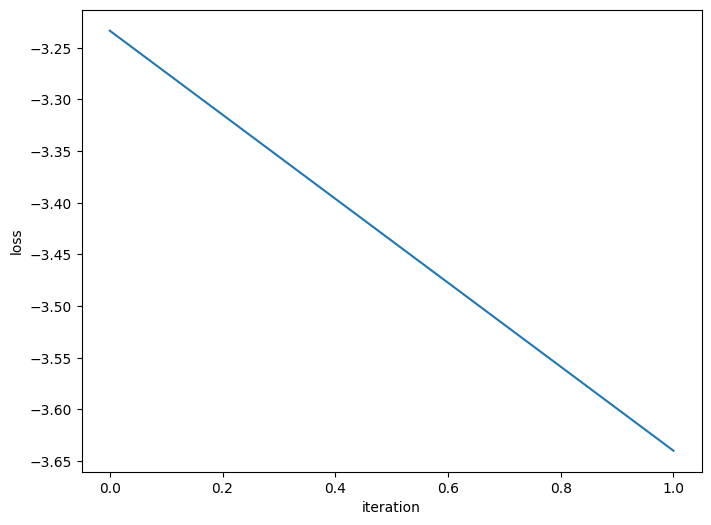

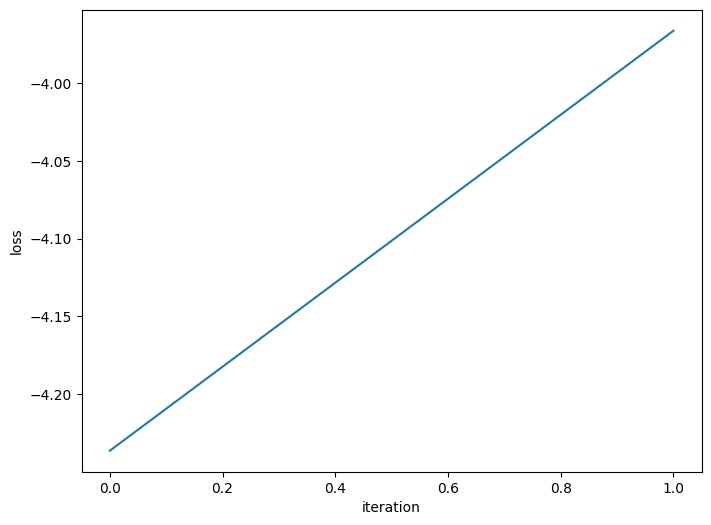

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -829.42021  validloss -634.30432±0.00000  bestvalidloss -634.30432  last_update 0
train: iter 1  trainloss -847.73865  validloss -681.12550±0.00000  bestvalidloss -681.12550  last_update 0
train: iter 2  trainloss -833.93802  validloss -675.50559±0.00000  bestvalidloss -681.12550  last_update 1
train: iter 3  trainloss -852.71092  validloss -695.82663±0.00000  bestvalidloss -695.82663  last_update 0
train: iter 4  trainloss -818.28395  validloss -665.10135±0.00000  bestvalidloss -695.82663  last_update 1
train: iter 5  trainloss -839.07708  validloss -666.75340±0.00000  bestvalidloss -695.82663  last_update 2
train: iter 6  trainloss -797.74874  validloss -618.75289±0.00000  bestvalidloss -695.82663  last_update 3
train: iter 7  trainloss -847.93837  validloss -691.23501±0.00000  bestvalidloss -695.82663  last_update 4
train: iter 8  trainloss -844.17475  validloss -701.86990±0.00000  bestvalidloss -701.86990  last_u

train: iter 76  trainloss -824.08282  validloss -601.80406±0.00000  bestvalidloss -701.86990  last_update 68
train: iter 77  trainloss -829.47412  validloss -663.64545±0.00000  bestvalidloss -701.86990  last_update 69
train: iter 78  trainloss -822.72510  validloss -659.19268±0.00000  bestvalidloss -701.86990  last_update 70
train: iter 79  trainloss -769.33650  validloss -635.74816±0.00000  bestvalidloss -701.86990  last_update 71
train: iter 80  trainloss -835.38095  validloss -662.25372±0.00000  bestvalidloss -701.86990  last_update 72
train: iter 81  trainloss -844.21870  validloss -678.61015±0.00000  bestvalidloss -701.86990  last_update 73
train: iter 82  trainloss -840.46541  validloss -675.39516±0.00000  bestvalidloss -701.86990  last_update 74
train: iter 83  trainloss -828.71073  validloss -643.38314±0.00000  bestvalidloss -701.86990  last_update 75
train: iter 84  trainloss -826.93207  validloss -656.67898±0.00000  bestvalidloss -701.86990  last_update 76
train: iter 85  tra

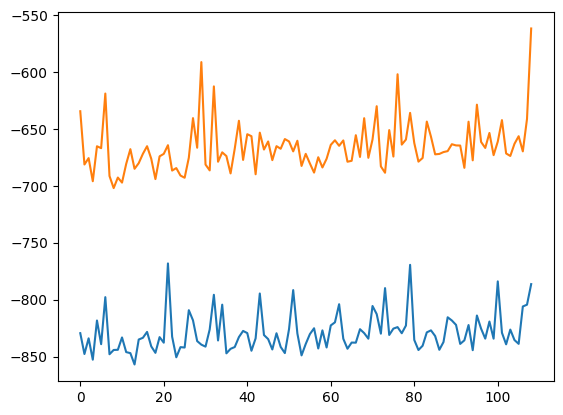

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-28 10:14:21.118048


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49
predict diverge [ -5.30163679   6.36938679   8.67900597 -31.8531112 ] [  0.20093731   1.4560141   -0.93697445 -10.22160407] [ 91.917595  20.42253  126.01955   29.298172] [45.958797 10.211265 63.009773 14.649086] sim_timestep 141

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.42559  validloss 0.58540±0.00000  bestvalidloss 0.58540  last_update 0
train: iter 1  trainloss 0.40178  validloss 0.39484±0.00000  bestvalidloss 0.39484  last_update 0
train: iter 2  trainloss 0.39076  validloss 0.34539±0.00000  bestvalidloss 0.34539  last_update 0
train: iter 3  trainloss 0.38599  validloss 0.34837±0.00000  bestvalidloss 0.34539  last_update 1
train: iter 4  trainloss 0.39038  validloss 0.34005±0.00000  bestvalidloss 0.34005  last_update 0
train: iter 5  trainloss 0.38660  validloss 0.33233±0.00000  bestvalidloss 0.33233  last_update 0
train: iter 6  trainloss 0.38035  validloss 0.33351±0.00000  bestvalidloss 0.33233  last_update 1
train: iter 7  trainloss 0.37239  validloss 0.34260±0.00000  bestvalidloss 0.33233  last_update 2
train: iter 8  trainloss 0.38185  validloss 0.34454±0.00000  bestvalidloss 0.33233  last_update 3
train: iter 9  trainloss 0.37395  validloss 0.33965±0.00000  bestvalidloss 0.33233  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.33973  validloss 0.34754±0.00000  bestvalidloss 0.33233  last_update 78
train: iter 84  trainloss 0.33673  validloss 0.36025±0.00000  bestvalidloss 0.33233  last_update 79
train: iter 85  trainloss 0.33912  validloss 0.34919±0.00000  bestvalidloss 0.33233  last_update 80
train: iter 86  trainloss 0.33719  validloss 0.34458±0.00000  bestvalidloss 0.33233  last_update 81
train: iter 87  trainloss 0.33855  validloss 0.34729±0.00000  bestvalidloss 0.33233  last_update 82
train: iter 88  trainloss 0.33773  validloss 0.34027±0.00000  bestvalidloss 0.33233  last_update 83
train: iter 89  trainloss 0.34085  validloss 0.36546±0.00000  bestvalidloss 0.33233  last_update 84
train: iter 90  trainloss 0.33762  validloss 0.33771±0.00000  bestvalidloss 0.33233  last_update 85
train: iter 91  trainloss 0.34221  validloss 0.34187±0.00000  bestvalidloss 0.33233  last_update 86
train: iter 92  trainloss 0.33541  validloss 0.34535±0.00000  bestvalidloss 0.33233  last_update 87


train_loss:  -4.130849426773191
valid_loss:  -4.594501813793183
weight_alpha 1.0 h_min_tilde -11.415121 ell_tilde -4.223579904177189 kappa_tilde 0.0003728971072647182
train_loss:  -4.524488826560973
valid_loss:  -3.6933886085510252
weight_alpha 0.1 h_min_tilde -11.415121 ell_tilde -4.358268782958984 kappa_tilde 0.0003764388918356806


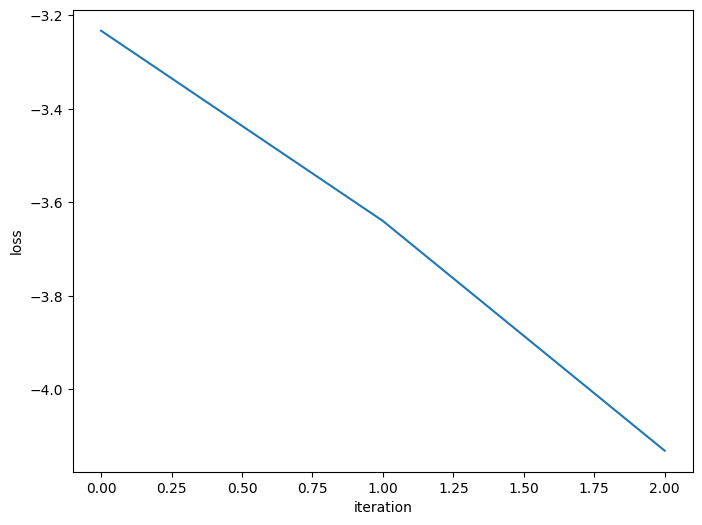

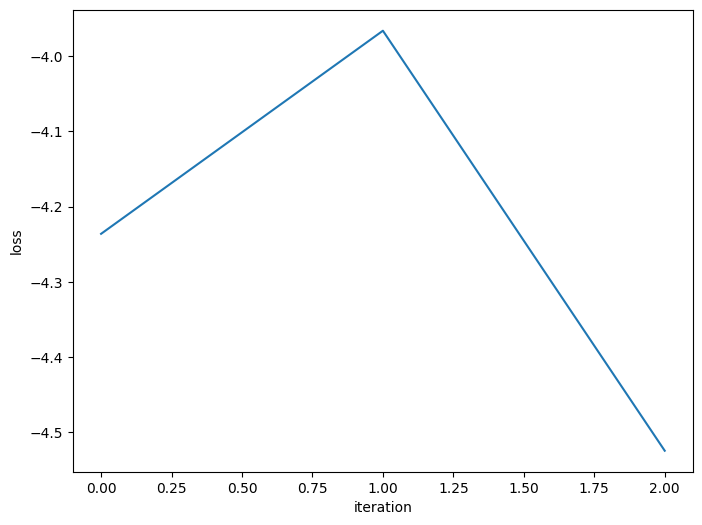

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -898.23187  validloss -738.89854±0.00000  bestvalidloss -738.89854  last_update 0
train: iter 1  trainloss -911.24741  validloss -720.49025±0.00000  bestvalidloss -738.89854  last_update 1
train: iter 2  trainloss -905.63085  validloss -710.35043±0.00000  bestvalidloss -738.89854  last_update 2
train: iter 3  trainloss -890.04737  validloss -743.45502±0.00000  bestvalidloss -743.45502  last_update 0
train: iter 4  trainloss -871.29657  validloss -638.73195±0.00000  bestvalidloss -743.45502  last_update 1
train: iter 5  trainloss -907.40937  validloss -720.28312±0.00000  bestvalidloss -743.45502  last_update 2
train: iter 6  trainloss -916.40800  validloss -733.01022±0.00000  bestvalidloss -743.45502  last_update 3
train: iter 7  trainloss -879.58553  validloss -706.40646±0.00000  bestvalidloss -743.45502  last_update 4
train: iter 8  trainloss -909.16313  validloss -706.98527±0.00000  bestvalidloss -743.45502  last_u

train: iter 76  trainloss -858.91063  validloss -682.52348±0.00000  bestvalidloss -750.18205  last_update 33
train: iter 77  trainloss -927.07472  validloss -749.04874±0.00000  bestvalidloss -750.18205  last_update 34
train: iter 78  trainloss -876.54510  validloss -706.49766±0.00000  bestvalidloss -750.18205  last_update 35
train: iter 79  trainloss -921.52325  validloss -742.37087±0.00000  bestvalidloss -750.18205  last_update 36
train: iter 80  trainloss -898.96050  validloss -738.13501±0.00000  bestvalidloss -750.18205  last_update 37
train: iter 81  trainloss -870.79800  validloss -582.22543±0.00000  bestvalidloss -750.18205  last_update 38
train: iter 82  trainloss -885.13225  validloss -724.81548±0.00000  bestvalidloss -750.18205  last_update 39
train: iter 83  trainloss -925.04638  validloss -737.37936±0.00000  bestvalidloss -750.18205  last_update 40
train: iter 84  trainloss -923.83482  validloss -746.61803±0.00000  bestvalidloss -750.18205  last_update 41
train: iter 85  tra

train: iter 151  trainloss -927.68041  validloss -728.56818±0.00000  bestvalidloss -758.81762  last_update 33
train: iter 152  trainloss -843.71145  validloss -684.52477±0.00000  bestvalidloss -758.81762  last_update 34
train: iter 153  trainloss -919.91858  validloss -697.41691±0.00000  bestvalidloss -758.81762  last_update 35
train: iter 154  trainloss -916.97740  validloss -692.78717±0.00000  bestvalidloss -758.81762  last_update 36
train: iter 155  trainloss -913.95902  validloss -713.13301±0.00000  bestvalidloss -758.81762  last_update 37
train: iter 156  trainloss -887.39562  validloss -731.34454±0.00000  bestvalidloss -758.81762  last_update 38
train: iter 157  trainloss -910.20549  validloss -721.12775±0.00000  bestvalidloss -758.81762  last_update 39
train: iter 158  trainloss -923.23834  validloss -720.58128±0.00000  bestvalidloss -758.81762  last_update 40
train: iter 159  trainloss -925.37545  validloss -673.21414±0.00000  bestvalidloss -758.81762  last_update 41
train: ite

train: iter 226  trainloss -926.24506  validloss -752.07873±0.00000  bestvalidloss -766.44335  last_update 1
train: iter 227  trainloss -885.81718  validloss -765.75231±0.00000  bestvalidloss -766.44335  last_update 2
train: iter 228  trainloss -923.37947  validloss -763.20354±0.00000  bestvalidloss -766.44335  last_update 3
train: iter 229  trainloss -910.03215  validloss -742.92930±0.00000  bestvalidloss -766.44335  last_update 4
train: iter 230  trainloss -911.05081  validloss -700.02375±0.00000  bestvalidloss -766.44335  last_update 5
train: iter 231  trainloss -931.95233  validloss -752.54798±0.00000  bestvalidloss -766.44335  last_update 6
train: iter 232  trainloss -931.75602  validloss -740.69535±0.00000  bestvalidloss -766.44335  last_update 7
train: iter 233  trainloss -934.64452  validloss -764.86310±0.00000  bestvalidloss -766.44335  last_update 8
train: iter 234  trainloss -941.50627  validloss -760.30503±0.00000  bestvalidloss -766.44335  last_update 9
train: iter 235  tr

train: iter 301  trainloss -937.35639  validloss -743.70844±0.00000  bestvalidloss -770.19771  last_update 3
train: iter 302  trainloss -900.95848  validloss -735.81145±0.00000  bestvalidloss -770.19771  last_update 4
train: iter 303  trainloss -906.35319  validloss -748.68211±0.00000  bestvalidloss -770.19771  last_update 5
train: iter 304  trainloss -920.15431  validloss -723.72390±0.00000  bestvalidloss -770.19771  last_update 6
train: iter 305  trainloss -918.52167  validloss -752.43897±0.00000  bestvalidloss -770.19771  last_update 7
train: iter 306  trainloss -947.21036  validloss -769.39335±0.00000  bestvalidloss -770.19771  last_update 8
train: iter 307  trainloss -932.76320  validloss -764.68033±0.00000  bestvalidloss -770.19771  last_update 9
train: iter 308  trainloss -937.51000  validloss -769.06457±0.00000  bestvalidloss -770.19771  last_update 10
train: iter 309  trainloss -930.07106  validloss -752.25875±0.00000  bestvalidloss -770.19771  last_update 11
train: iter 310  

train: iter 376  trainloss -937.50492  validloss -698.22726±0.00000  bestvalidloss -784.43119  last_update 22
train: iter 377  trainloss -922.89630  validloss -784.78712±0.00000  bestvalidloss -784.78712  last_update 0
train: iter 378  trainloss -936.30769  validloss -763.22479±0.00000  bestvalidloss -784.78712  last_update 1
train: iter 379  trainloss -942.51671  validloss -782.07598±0.00000  bestvalidloss -784.78712  last_update 2
train: iter 380  trainloss -919.93471  validloss -752.95328±0.00000  bestvalidloss -784.78712  last_update 3
train: iter 381  trainloss -928.65675  validloss -726.48145±0.00000  bestvalidloss -784.78712  last_update 4
train: iter 382  trainloss -902.84280  validloss -769.67803±0.00000  bestvalidloss -784.78712  last_update 5
train: iter 383  trainloss -907.62590  validloss -650.11515±0.00000  bestvalidloss -784.78712  last_update 6
train: iter 384  trainloss -932.58669  validloss -763.44465±0.00000  bestvalidloss -784.78712  last_update 7
train: iter 385  t

train: iter 451  trainloss -942.92776  validloss -787.47681±0.00000  bestvalidloss -798.75769  last_update 5
train: iter 452  trainloss -804.15443  validloss -783.37834±0.00000  bestvalidloss -798.75769  last_update 6
train: iter 453  trainloss -897.92811  validloss -651.62336±0.00000  bestvalidloss -798.75769  last_update 7
train: iter 454  trainloss -927.60884  validloss -718.41328±0.00000  bestvalidloss -798.75769  last_update 8
train: iter 455  trainloss -921.41449  validloss -736.67301±0.00000  bestvalidloss -798.75769  last_update 9
train: iter 456  trainloss -941.58441  validloss -757.42050±0.00000  bestvalidloss -798.75769  last_update 10
train: iter 457  trainloss -944.11937  validloss -781.13735±0.00000  bestvalidloss -798.75769  last_update 11
train: iter 458  trainloss -940.78932  validloss -760.52500±0.00000  bestvalidloss -798.75769  last_update 12
train: iter 459  trainloss -944.70342  validloss -777.41298±0.00000  bestvalidloss -798.75769  last_update 13
train: iter 460

train: iter 526  trainloss -956.01815  validloss -776.16259±0.00000  bestvalidloss -800.15878  last_update 17
train: iter 527  trainloss -956.67590  validloss -787.17784±0.00000  bestvalidloss -800.15878  last_update 18
train: iter 528  trainloss -902.33891  validloss -772.32161±0.00000  bestvalidloss -800.15878  last_update 19
train: iter 529  trainloss -945.02913  validloss -767.07994±0.00000  bestvalidloss -800.15878  last_update 20
train: iter 530  trainloss -943.95105  validloss -805.79065±0.00000  bestvalidloss -805.79065  last_update 0
train: iter 531  trainloss -958.61002  validloss -781.95101±0.00000  bestvalidloss -805.79065  last_update 1
train: iter 532  trainloss -938.43386  validloss -709.82587±0.00000  bestvalidloss -805.79065  last_update 2
train: iter 533  trainloss -951.33305  validloss -780.42325±0.00000  bestvalidloss -805.79065  last_update 3
train: iter 534  trainloss -948.14303  validloss -775.22248±0.00000  bestvalidloss -805.79065  last_update 4
train: iter 535

train: iter 601  trainloss -949.13739  validloss -775.01479±0.00000  bestvalidloss -805.79065  last_update 71
train: iter 602  trainloss -943.07916  validloss -760.06966±0.00000  bestvalidloss -805.79065  last_update 72
train: iter 603  trainloss -968.94436  validloss -755.33619±0.00000  bestvalidloss -805.79065  last_update 73
train: iter 604  trainloss -970.87429  validloss -802.98747±0.00000  bestvalidloss -805.79065  last_update 74
train: iter 605  trainloss -955.79314  validloss -791.40413±0.00000  bestvalidloss -805.79065  last_update 75
train: iter 606  trainloss -902.72283  validloss -700.20534±0.00000  bestvalidloss -805.79065  last_update 76
train: iter 607  trainloss -961.68677  validloss -791.84048±0.00000  bestvalidloss -805.79065  last_update 77
train: iter 608  trainloss -956.30900  validloss -806.56267±0.00000  bestvalidloss -806.56267  last_update 0
train: iter 609  trainloss -957.60130  validloss -788.47743±0.00000  bestvalidloss -806.56267  last_update 1
train: iter 

train: iter 676  trainloss -968.98838  validloss -790.85453±0.00000  bestvalidloss -817.44689  last_update 14
train: iter 677  trainloss -977.36399  validloss -812.66894±0.00000  bestvalidloss -817.44689  last_update 15
train: iter 678  trainloss -976.32986  validloss -806.21461±0.00000  bestvalidloss -817.44689  last_update 16
train: iter 679  trainloss -979.74666  validloss -806.14524±0.00000  bestvalidloss -817.44689  last_update 17
train: iter 680  trainloss -979.33470  validloss -797.91882±0.00000  bestvalidloss -817.44689  last_update 18
train: iter 681  trainloss -891.22409  validloss -815.91521±0.00000  bestvalidloss -817.44689  last_update 19
train: iter 682  trainloss -950.85253  validloss -726.57886±0.00000  bestvalidloss -817.44689  last_update 20
train: iter 683  trainloss -961.11282  validloss -765.01655±0.00000  bestvalidloss -817.44689  last_update 21
train: iter 684  trainloss -962.76945  validloss -750.06545±0.00000  bestvalidloss -817.44689  last_update 22
train: ite

train: iter 751  trainloss -985.74849  validloss -804.59376±0.00000  bestvalidloss -817.44689  last_update 89
train: iter 752  trainloss -984.00901  validloss -803.82766±0.00000  bestvalidloss -817.44689  last_update 90
train: iter 753  trainloss -986.52002  validloss -820.32764±0.00000  bestvalidloss -820.32764  last_update 0
train: iter 754  trainloss -955.44475  validloss -760.23645±0.00000  bestvalidloss -820.32764  last_update 1
train: iter 755  trainloss -979.60353  validloss -779.60565±0.00000  bestvalidloss -820.32764  last_update 2
train: iter 756  trainloss -965.42824  validloss -791.67321±0.00000  bestvalidloss -820.32764  last_update 3
train: iter 757  trainloss -973.44061  validloss -792.46975±0.00000  bestvalidloss -820.32764  last_update 4
train: iter 758  trainloss -984.64539  validloss -779.25543±0.00000  bestvalidloss -820.32764  last_update 5
train: iter 759  trainloss -985.89284  validloss -820.29562±0.00000  bestvalidloss -820.32764  last_update 6
train: iter 760  

train: iter 826  trainloss -983.94677  validloss -814.77378±0.00000  bestvalidloss -828.74009  last_update 2
train: iter 827  trainloss -987.10425  validloss -817.27926±0.00000  bestvalidloss -828.74009  last_update 3
train: iter 828  trainloss -963.36172  validloss -806.62060±0.00000  bestvalidloss -828.74009  last_update 4
train: iter 829  trainloss -941.67267  validloss -710.13998±0.00000  bestvalidloss -828.74009  last_update 5
train: iter 830  trainloss -992.23790  validloss -806.49029±0.00000  bestvalidloss -828.74009  last_update 6
train: iter 831  trainloss -999.26741  validloss -819.24804±0.00000  bestvalidloss -828.74009  last_update 7
train: iter 832  trainloss -999.11556  validloss -807.42227±0.00000  bestvalidloss -828.74009  last_update 8
train: iter 833  trainloss -989.44101  validloss -787.04574±0.00000  bestvalidloss -828.74009  last_update 9
train: iter 834  trainloss -979.27118  validloss -791.67912±0.00000  bestvalidloss -828.74009  last_update 10
train: iter 835  t

train: iter 901  trainloss -1001.70578  validloss -811.01128±0.00000  bestvalidloss -832.05721  last_update 38
train: iter 902  trainloss -1000.72039  validloss -819.24271±0.00000  bestvalidloss -832.05721  last_update 39
train: iter 903  trainloss -1017.66749  validloss -826.50236±0.00000  bestvalidloss -832.05721  last_update 40
train: iter 904  trainloss -998.65770  validloss -825.01887±0.00000  bestvalidloss -832.05721  last_update 41
train: iter 905  trainloss -1002.00929  validloss -807.55702±0.00000  bestvalidloss -832.05721  last_update 42
train: iter 906  trainloss -998.71918  validloss -831.13155±0.00000  bestvalidloss -832.05721  last_update 43
train: iter 907  trainloss -991.37437  validloss -810.52700±0.00000  bestvalidloss -832.05721  last_update 44
train: iter 908  trainloss -980.31609  validloss -826.89302±0.00000  bestvalidloss -832.05721  last_update 45
train: iter 909  trainloss -1003.59584  validloss -802.66139±0.00000  bestvalidloss -832.05721  last_update 46
train

train: iter 976  trainloss -1003.00755  validloss -818.14228±0.00000  bestvalidloss -837.23196  last_update 26
train: iter 977  trainloss -988.80270  validloss -824.26744±0.00000  bestvalidloss -837.23196  last_update 27
train: iter 978  trainloss -985.97478  validloss -779.30737±0.00000  bestvalidloss -837.23196  last_update 28
train: iter 979  trainloss -1002.29018  validloss -813.30243±0.00000  bestvalidloss -837.23196  last_update 29
train: iter 980  trainloss -1006.82168  validloss -797.23750±0.00000  bestvalidloss -837.23196  last_update 30
train: iter 981  trainloss -1002.28437  validloss -803.59520±0.00000  bestvalidloss -837.23196  last_update 31
train: iter 982  trainloss -1013.47999  validloss -811.68131±0.00000  bestvalidloss -837.23196  last_update 32
train: iter 983  trainloss -1000.07317  validloss -819.31486±0.00000  bestvalidloss -837.23196  last_update 33
train: iter 984  trainloss -994.89387  validloss -794.47588±0.00000  bestvalidloss -837.23196  last_update 34
trai

train: iter 1050  trainloss -1001.83627  validloss -808.17652±0.00000  bestvalidloss -839.46964  last_update 10
train: iter 1051  trainloss -1018.09402  validloss -818.63556±0.00000  bestvalidloss -839.46964  last_update 11
train: iter 1052  trainloss -992.47197  validloss -826.88449±0.00000  bestvalidloss -839.46964  last_update 12
train: iter 1053  trainloss -997.04805  validloss -765.31882±0.00000  bestvalidloss -839.46964  last_update 13
train: iter 1054  trainloss -1003.64184  validloss -802.40176±0.00000  bestvalidloss -839.46964  last_update 14
train: iter 1055  trainloss -1013.13103  validloss -815.86871±0.00000  bestvalidloss -839.46964  last_update 15
train: iter 1056  trainloss -1012.19361  validloss -841.46915±0.00000  bestvalidloss -841.46915  last_update 0
train: iter 1057  trainloss -980.17528  validloss -763.36805±0.00000  bestvalidloss -841.46915  last_update 1
train: iter 1058  trainloss -998.53191  validloss -781.07344±0.00000  bestvalidloss -841.46915  last_update 2

train: iter 1124  trainloss -1011.07910  validloss -821.43513±0.00000  bestvalidloss -842.67101  last_update 2
train: iter 1125  trainloss -1018.15074  validloss -841.97970±0.00000  bestvalidloss -842.67101  last_update 3
train: iter 1126  trainloss -1006.80433  validloss -832.62446±0.00000  bestvalidloss -842.67101  last_update 4
train: iter 1127  trainloss -1020.44709  validloss -819.05076±0.00000  bestvalidloss -842.67101  last_update 5
train: iter 1128  trainloss -969.26308  validloss -812.97385±0.00000  bestvalidloss -842.67101  last_update 6
train: iter 1129  trainloss -894.96244  validloss -498.42545±0.00000  bestvalidloss -842.67101  last_update 7
train: iter 1130  trainloss -989.42335  validloss -773.59582±0.00000  bestvalidloss -842.67101  last_update 8
train: iter 1131  trainloss -1004.97163  validloss -791.37359±0.00000  bestvalidloss -842.67101  last_update 9
train: iter 1132  trainloss -1005.29696  validloss -807.93819±0.00000  bestvalidloss -842.67101  last_update 10
tra

train: iter 1198  trainloss -1021.87971  validloss -829.24930±0.00000  bestvalidloss -842.67101  last_update 76
train: iter 1199  trainloss -1024.69634  validloss -819.82327±0.00000  bestvalidloss -842.67101  last_update 77
train: iter 1200  trainloss -1030.83806  validloss -845.28979±0.00000  bestvalidloss -845.28979  last_update 0
train: iter 1201  trainloss -955.90833  validloss -802.35894±0.00000  bestvalidloss -845.28979  last_update 1
train: iter 1202  trainloss -999.61035  validloss -722.57464±0.00000  bestvalidloss -845.28979  last_update 2
train: iter 1203  trainloss -1028.53277  validloss -824.89333±0.00000  bestvalidloss -845.28979  last_update 3
train: iter 1204  trainloss -1014.94209  validloss -828.47942±0.00000  bestvalidloss -845.28979  last_update 4
train: iter 1205  trainloss -1009.07211  validloss -820.65554±0.00000  bestvalidloss -845.28979  last_update 5
train: iter 1206  trainloss -1021.54226  validloss -819.39547±0.00000  bestvalidloss -845.28979  last_update 6
t

train: iter 1272  trainloss -1024.24700  validloss -829.20507±0.00000  bestvalidloss -845.28979  last_update 72
train: iter 1273  trainloss -1025.72351  validloss -833.17397±0.00000  bestvalidloss -845.28979  last_update 73
train: iter 1274  trainloss -1027.31516  validloss -852.83565±0.00000  bestvalidloss -852.83565  last_update 0
train: iter 1275  trainloss -996.65803  validloss -787.33430±0.00000  bestvalidloss -852.83565  last_update 1
train: iter 1276  trainloss -1014.99471  validloss -834.22343±0.00000  bestvalidloss -852.83565  last_update 2
train: iter 1277  trainloss -1022.12182  validloss -837.95655±0.00000  bestvalidloss -852.83565  last_update 3
train: iter 1278  trainloss -1017.47444  validloss -839.35465±0.00000  bestvalidloss -852.83565  last_update 4
train: iter 1279  trainloss -1003.18807  validloss -813.80865±0.00000  bestvalidloss -852.83565  last_update 5
train: iter 1280  trainloss -1024.31892  validloss -830.64712±0.00000  bestvalidloss -852.83565  last_update 6


train: iter 1346  trainloss -1015.94085  validloss -824.11368±0.00000  bestvalidloss -852.83565  last_update 72
train: iter 1347  trainloss -1028.88463  validloss -824.87056±0.00000  bestvalidloss -852.83565  last_update 73
train: iter 1348  trainloss -1020.18970  validloss -811.24551±0.00000  bestvalidloss -852.83565  last_update 74
train: iter 1349  trainloss -1021.40269  validloss -820.21076±0.00000  bestvalidloss -852.83565  last_update 75
train: iter 1350  trainloss -1010.16551  validloss -826.94820±0.00000  bestvalidloss -852.83565  last_update 76
train: iter 1351  trainloss -1024.80373  validloss -828.01327±0.00000  bestvalidloss -852.83565  last_update 77
train: iter 1352  trainloss -984.70071  validloss -826.85562±0.00000  bestvalidloss -852.83565  last_update 78
train: iter 1353  trainloss -1003.58272  validloss -690.58518±0.00000  bestvalidloss -852.83565  last_update 79
train: iter 1354  trainloss -1019.33011  validloss -832.94381±0.00000  bestvalidloss -852.83565  last_upd

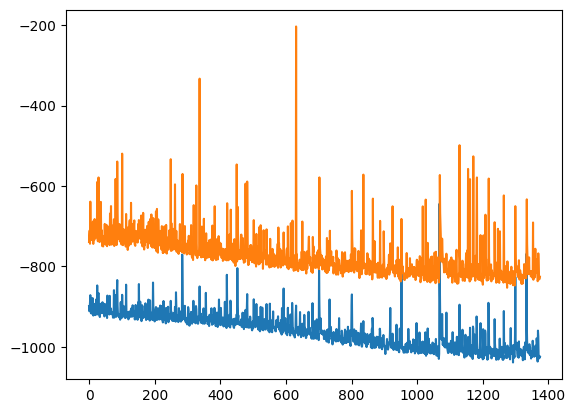

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-28 10:50:16.418658


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.69171  validloss 3.62439±0.00000  bestvalidloss 3.62439  last_update 0
train: iter 1  trainloss 1.01094  validloss 0.82852±0.00000  bestvalidloss 0.82852  last_update 0
train: iter 2  trainloss 0.90843  validloss 0.71823±0.00000  bestvalidloss 0.71823  last_update 0
train: iter 3  trainloss 0.85914  validloss 0.69491±0.00000  bestvalidloss 0.69491  last_update 0
train: iter 4  trainloss 0.83018  validloss 0.68355±0.00000  bestvalidloss 0.68355  last_update 0
train: iter 5  trainloss 0.80444  validloss 0.68074±0.00000  bestvalidloss 0.68074  last_update 0
train: iter 6  trainloss 0.78403  validloss 0.66325±0.00000  bestvalidloss 0.66325  last_update 0
train: iter 7  trainloss 0.76573  validloss 0.65440±0.00000  bestvalidloss 0.65440  last_update 0
train: iter 8  trainloss 0.74873  validloss 0.64705±0.00000  bestvalidloss 0.64705  last_update 0
train: iter 9  trainloss 0.73415  validloss 0.64668±0.00000  bestvalidloss 0.64668  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.57590  validloss 0.56787±0.00000  bestvalidloss 0.55227  last_update 6
train: iter 84  trainloss 0.57825  validloss 0.54760±0.00000  bestvalidloss 0.54760  last_update 0
train: iter 85  trainloss 0.57375  validloss 0.56227±0.00000  bestvalidloss 0.54760  last_update 1
train: iter 86  trainloss 0.57533  validloss 0.55232±0.00000  bestvalidloss 0.54760  last_update 2
train: iter 87  trainloss 0.57426  validloss 0.56414±0.00000  bestvalidloss 0.54760  last_update 3
train: iter 88  trainloss 0.57229  validloss 0.56228±0.00000  bestvalidloss 0.54760  last_update 4
train: iter 89  trainloss 0.56435  validloss 0.55676±0.00000  bestvalidloss 0.54760  last_update 5
train: iter 90  trainloss 0.57592  validloss 0.56852±0.00000  bestvalidloss 0.54760  last_update 6
train: iter 91  trainloss 0.57070  validloss 0.56248±0.00000  bestvalidloss 0.54760  last_update 7
train: iter 92  trainloss 0.57140  validloss 0.55098±0.00000  bestvalidloss 0.54760  last_update 8
train: ite

train: iter 165  trainloss 0.52857  validloss 0.55139±0.00000  bestvalidloss 0.53186  last_update 22
train: iter 166  trainloss 0.53457  validloss 0.54336±0.00000  bestvalidloss 0.53186  last_update 23
train: iter 167  trainloss 0.53021  validloss 0.54588±0.00000  bestvalidloss 0.53186  last_update 24
train: iter 168  trainloss 0.52796  validloss 0.54256±0.00000  bestvalidloss 0.53186  last_update 25
train: iter 169  trainloss 0.53370  validloss 0.56455±0.00000  bestvalidloss 0.53186  last_update 26
train: iter 170  trainloss 0.52536  validloss 0.54752±0.00000  bestvalidloss 0.53186  last_update 27
train: iter 171  trainloss 0.53260  validloss 0.52757±0.00000  bestvalidloss 0.52757  last_update 0
train: iter 172  trainloss 0.52539  validloss 0.53802±0.00000  bestvalidloss 0.52757  last_update 1
train: iter 173  trainloss 0.53399  validloss 0.55449±0.00000  bestvalidloss 0.52757  last_update 2
train: iter 174  trainloss 0.52243  validloss 0.54401±0.00000  bestvalidloss 0.52757  last_upd

train: iter 247  trainloss 0.50455  validloss 0.55536±0.00000  bestvalidloss 0.52014  last_update 4
train: iter 248  trainloss 0.50426  validloss 0.53602±0.00000  bestvalidloss 0.52014  last_update 5
train: iter 249  trainloss 0.50440  validloss 0.52538±0.00000  bestvalidloss 0.52014  last_update 6
train: iter 250  trainloss 0.50761  validloss 0.53093±0.00000  bestvalidloss 0.52014  last_update 7
train: iter 251  trainloss 0.50360  validloss 0.53959±0.00000  bestvalidloss 0.52014  last_update 8
train: iter 252  trainloss 0.50498  validloss 0.54089±0.00000  bestvalidloss 0.52014  last_update 9
train: iter 253  trainloss 0.50300  validloss 0.53921±0.00000  bestvalidloss 0.52014  last_update 10
train: iter 254  trainloss 0.50583  validloss 0.55998±0.00000  bestvalidloss 0.52014  last_update 11
train: iter 255  trainloss 0.50441  validloss 0.53046±0.00000  bestvalidloss 0.52014  last_update 12
train: iter 256  trainloss 0.50470  validloss 0.54746±0.00000  bestvalidloss 0.52014  last_update

train: iter 329  trainloss 0.48950  validloss 0.52770±0.00000  bestvalidloss 0.51202  last_update 16
train: iter 330  trainloss 0.48587  validloss 0.54625±0.00000  bestvalidloss 0.51202  last_update 17
train: iter 331  trainloss 0.48791  validloss 0.51802±0.00000  bestvalidloss 0.51202  last_update 18
train: iter 332  trainloss 0.48408  validloss 0.54697±0.00000  bestvalidloss 0.51202  last_update 19
train: iter 333  trainloss 0.48174  validloss 0.52811±0.00000  bestvalidloss 0.51202  last_update 20
train: iter 334  trainloss 0.48368  validloss 0.53492±0.00000  bestvalidloss 0.51202  last_update 21
train: iter 335  trainloss 0.49102  validloss 0.53318±0.00000  bestvalidloss 0.51202  last_update 22
train: iter 336  trainloss 0.48735  validloss 0.50822±0.00000  bestvalidloss 0.50822  last_update 0
train: iter 337  trainloss 0.48604  validloss 0.51407±0.00000  bestvalidloss 0.50822  last_update 1
train: iter 338  trainloss 0.48544  validloss 0.54269±0.00000  bestvalidloss 0.50822  last_up

train: iter 411  trainloss 0.47102  validloss 0.54511±0.00000  bestvalidloss 0.50464  last_update 51
train: iter 412  trainloss 0.47021  validloss 0.53306±0.00000  bestvalidloss 0.50464  last_update 52
train: iter 413  trainloss 0.46961  validloss 0.54172±0.00000  bestvalidloss 0.50464  last_update 53
train: iter 414  trainloss 0.47328  validloss 0.52233±0.00000  bestvalidloss 0.50464  last_update 54
train: iter 415  trainloss 0.47217  validloss 0.54286±0.00000  bestvalidloss 0.50464  last_update 55
train: iter 416  trainloss 0.47596  validloss 0.52120±0.00000  bestvalidloss 0.50464  last_update 56
train: iter 417  trainloss 0.47213  validloss 0.52248±0.00000  bestvalidloss 0.50464  last_update 57
train: iter 418  trainloss 0.47781  validloss 0.54977±0.00000  bestvalidloss 0.50464  last_update 58
train: iter 419  trainloss 0.47497  validloss 0.53488±0.00000  bestvalidloss 0.50464  last_update 59
train: iter 420  trainloss 0.46905  validloss 0.53167±0.00000  bestvalidloss 0.50464  last_

train_loss:  -6.175865320247412
valid_loss:  -7.31868858013153
weight_alpha 1.0 h_min_tilde -11.621996 ell_tilde -6.404429972224235 kappa_tilde 0.0004377901905527249
train_loss:  -5.5417248435020445
valid_loss:  -4.842807065582275
weight_alpha 0.1 h_min_tilde -11.621996 ell_tilde -5.401941287918091 kappa_tilde 0.00040096170881383935


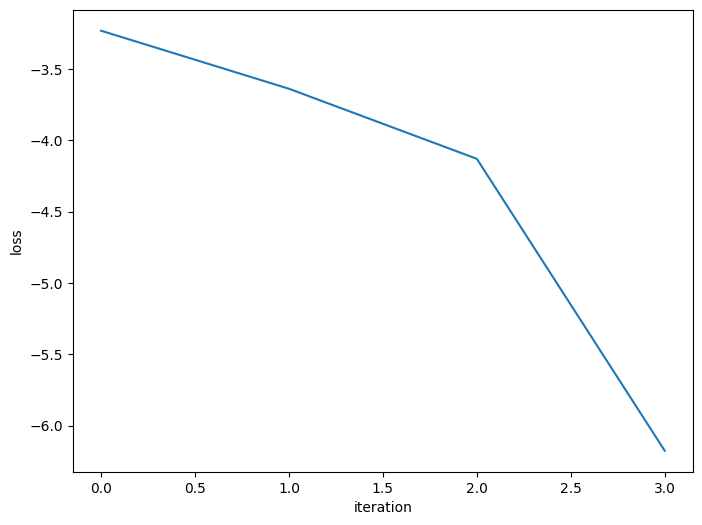

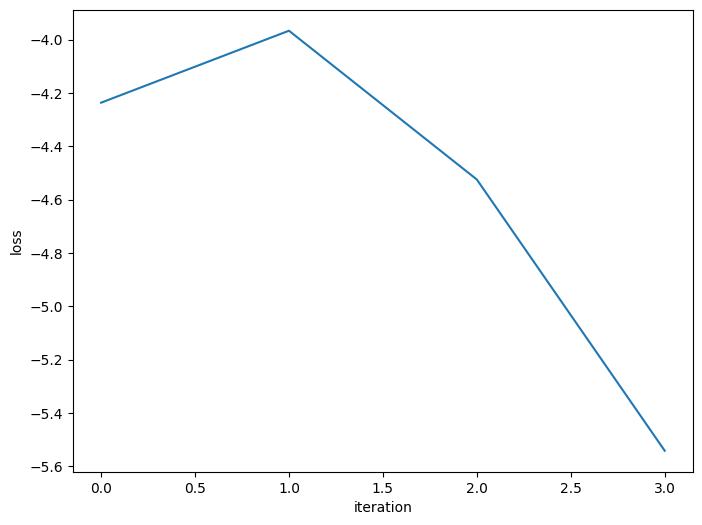

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1098.95904  validloss -971.13901±0.00000  bestvalidloss -971.13901  last_update 0
train: iter 1  trainloss -1098.00569  validloss -924.99860±0.00000  bestvalidloss -971.13901  last_update 1
train: iter 2  trainloss -1098.02106  validloss -948.85819±0.00000  bestvalidloss -971.13901  last_update 2
train: iter 3  trainloss -1112.68448  validloss -963.44733±0.00000  bestvalidloss -971.13901  last_update 3
train: iter 4  trainloss -1109.96549  validloss -970.03398±0.00000  bestvalidloss -971.13901  last_update 4
train: iter 5  trainloss -1098.30552  validloss -942.44633±0.00000  bestvalidloss -971.13901  last_update 5
train: iter 6  trainloss -1097.31038  validloss -956.56609±0.00000  bestvalidloss -971.13901  last_update 6
train: iter 7  trainloss -1098.24975  validloss -987.21248±0.00000  bestvalidloss -987.21248  last_update 0
train: iter 8  trainloss -1104.79327  validloss -889.49118±0.00000  bestvalidloss -987.2124

train: iter 74  trainloss -1088.55941  validloss -970.99348±0.00000  bestvalidloss -1006.48882  last_update 58
train: iter 75  trainloss -1097.67053  validloss -945.33246±0.00000  bestvalidloss -1006.48882  last_update 59
train: iter 76  trainloss -1089.99649  validloss -927.25050±0.00000  bestvalidloss -1006.48882  last_update 60
train: iter 77  trainloss -1098.07920  validloss -942.52820±0.00000  bestvalidloss -1006.48882  last_update 61
train: iter 78  trainloss -1112.49888  validloss -974.00040±0.00000  bestvalidloss -1006.48882  last_update 62
train: iter 79  trainloss -1120.58066  validloss -965.12042±0.00000  bestvalidloss -1006.48882  last_update 63
train: iter 80  trainloss -1104.63563  validloss -958.49981±0.00000  bestvalidloss -1006.48882  last_update 64
train: iter 81  trainloss -1048.13602  validloss -991.06685±0.00000  bestvalidloss -1006.48882  last_update 65
train: iter 82  trainloss -1041.92162  validloss -848.32412±0.00000  bestvalidloss -1006.48882  last_update 66
t

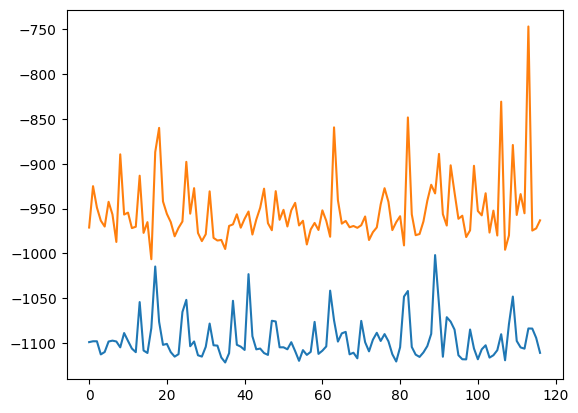

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-28 11:22:04.043778


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.51432  validloss 0.62362±0.00000  bestvalidloss 0.62362  last_update 0
train: iter 1  trainloss 0.49691  validloss 0.58390±0.00000  bestvalidloss 0.58390  last_update 0
train: iter 2  trainloss 0.49508  validloss 0.58118±0.00000  bestvalidloss 0.58118  last_update 0
train: iter 3  trainloss 0.48795  validloss 0.56706±0.00000  bestvalidloss 0.56706  last_update 0
train: iter 4  trainloss 0.48510  validloss 0.56716±0.00000  bestvalidloss 0.56706  last_update 1
train: iter 5  trainloss 0.48984  validloss 0.57175±0.00000  bestvalidloss 0.56706  last_update 2
train: iter 6  trainloss 0.48480  validloss 0.56144±0.00000  bestvalidloss 0.56144  last_update 0
train: iter 7  trainloss 0.48333  validloss 0.56355±0.00000  bestvalidloss 0.56144  last_update 1
train: iter 8  trainloss 0.48137  validloss 0.59384±0.00000  bestvalidloss 0.56144  last_update 2
train: iter 9  trainloss 0.48524  validloss 0.59466±0.00000  bestvalidloss 0.56144  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.45584  validloss 0.59260±0.00000  bestvalidloss 0.53541  last_update 15
train: iter 84  trainloss 0.45325  validloss 0.54752±0.00000  bestvalidloss 0.53541  last_update 16
train: iter 85  trainloss 0.45361  validloss 0.56342±0.00000  bestvalidloss 0.53541  last_update 17
train: iter 86  trainloss 0.45895  validloss 0.55698±0.00000  bestvalidloss 0.53541  last_update 18
train: iter 87  trainloss 0.45522  validloss 0.57029±0.00000  bestvalidloss 0.53541  last_update 19
train: iter 88  trainloss 0.45349  validloss 0.56573±0.00000  bestvalidloss 0.53541  last_update 20
train: iter 89  trainloss 0.45493  validloss 0.55561±0.00000  bestvalidloss 0.53541  last_update 21
train: iter 90  trainloss 0.45587  validloss 0.55979±0.00000  bestvalidloss 0.53541  last_update 22
train: iter 91  trainloss 0.45315  validloss 0.57674±0.00000  bestvalidloss 0.53541  last_update 23
train: iter 92  trainloss 0.45656  validloss 0.55603±0.00000  bestvalidloss 0.53541  last_update 24


train: iter 165  trainloss 0.44629  validloss 0.57324±0.00000  bestvalidloss 0.52924  last_update 33
train: iter 166  trainloss 0.43844  validloss 0.58737±0.00000  bestvalidloss 0.52924  last_update 34
train: iter 167  trainloss 0.44819  validloss 0.57299±0.00000  bestvalidloss 0.52924  last_update 35
train: iter 168  trainloss 0.45230  validloss 0.55931±0.00000  bestvalidloss 0.52924  last_update 36
train: iter 169  trainloss 0.44213  validloss 0.57018±0.00000  bestvalidloss 0.52924  last_update 37
train: iter 170  trainloss 0.43946  validloss 0.57174±0.00000  bestvalidloss 0.52924  last_update 38
train: iter 171  trainloss 0.44012  validloss 0.57060±0.00000  bestvalidloss 0.52924  last_update 39
train: iter 172  trainloss 0.43897  validloss 0.55193±0.00000  bestvalidloss 0.52924  last_update 40
train: iter 173  trainloss 0.43968  validloss 0.55666±0.00000  bestvalidloss 0.52924  last_update 41
train: iter 174  trainloss 0.44280  validloss 0.55239±0.00000  bestvalidloss 0.52924  last_

train_loss:  -5.733934432452918
valid_loss:  -7.439343477630615
weight_alpha 1.0 h_min_tilde -11.66056 ell_tilde -6.075016241488457 kappa_tilde 0.0004231236342036493
train_loss:  -5.246301546764374
valid_loss:  -4.451193231582643
weight_alpha 0.1 h_min_tilde -11.66056 ell_tilde -5.087279883728027 kappa_tilde 0.00039003981474277


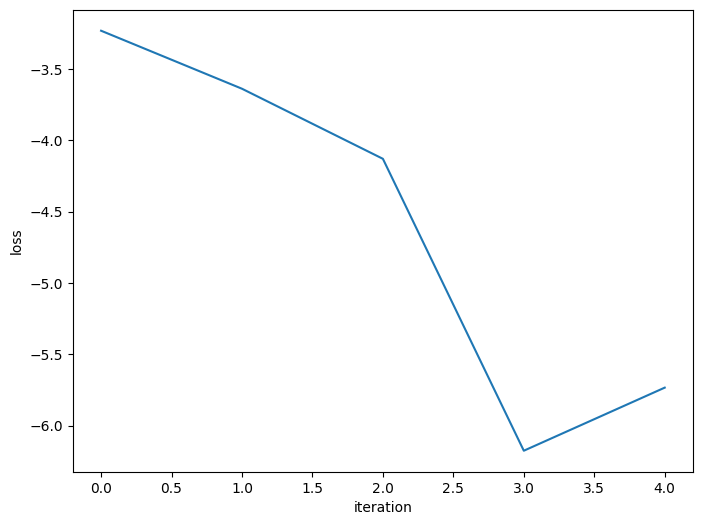

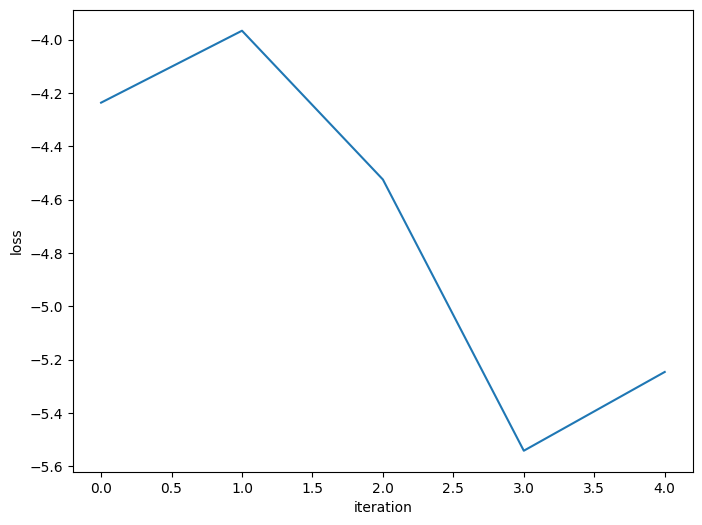

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1033.31326  validloss -888.58333±0.00000  bestvalidloss -888.58333  last_update 0
train: iter 1  trainloss -1043.84129  validloss -848.20479±0.00000  bestvalidloss -888.58333  last_update 1
train: iter 2  trainloss -1057.42442  validloss -904.99430±0.00000  bestvalidloss -904.99430  last_update 0
train: iter 3  trainloss -1057.65966  validloss -889.19008±0.00000  bestvalidloss -904.99430  last_update 1
train: iter 4  trainloss -1057.55518  validloss -887.78224±0.00000  bestvalidloss -904.99430  last_update 2
train: iter 5  trainloss -1061.73498  validloss -916.74942±0.00000  bestvalidloss -916.74942  last_update 0
train: iter 6  trainloss -1019.39073  validloss -863.34155±0.00000  bestvalidloss -916.74942  last_update 1
train: iter 7  trainloss -1052.76762  validloss -870.58939±0.00000  bestvalidloss -916.74942  last_update 2
train: iter 8  trainloss -1056.44508  validloss -903.64366±0.00000  bestvalidloss -916.7494

train: iter 75  trainloss -1061.26651  validloss -906.38059±0.00000  bestvalidloss -933.88359  last_update 5
train: iter 76  trainloss -1049.33157  validloss -911.06702±0.00000  bestvalidloss -933.88359  last_update 6
train: iter 77  trainloss -1059.73243  validloss -926.52924±0.00000  bestvalidloss -933.88359  last_update 7
train: iter 78  trainloss -1066.29509  validloss -919.80343±0.00000  bestvalidloss -933.88359  last_update 8
train: iter 79  trainloss -1064.85794  validloss -900.74324±0.00000  bestvalidloss -933.88359  last_update 9
train: iter 80  trainloss -981.98675  validloss -872.39522±0.00000  bestvalidloss -933.88359  last_update 10
train: iter 81  trainloss -1052.10260  validloss -891.63925±0.00000  bestvalidloss -933.88359  last_update 11
train: iter 82  trainloss -1055.94976  validloss -909.82544±0.00000  bestvalidloss -933.88359  last_update 12
train: iter 83  trainloss -1040.04042  validloss -892.01345±0.00000  bestvalidloss -933.88359  last_update 13
train: iter 84  

train: iter 150  trainloss -1041.77625  validloss -881.26365±0.00000  bestvalidloss -933.88359  last_update 80
train: iter 151  trainloss -1006.06531  validloss -898.57425±0.00000  bestvalidloss -933.88359  last_update 81
train: iter 152  trainloss -1046.69785  validloss -913.75388±0.00000  bestvalidloss -933.88359  last_update 82
train: iter 153  trainloss -1051.44031  validloss -910.13246±0.00000  bestvalidloss -933.88359  last_update 83
train: iter 154  trainloss -1054.82816  validloss -909.70783±0.00000  bestvalidloss -933.88359  last_update 84
train: iter 155  trainloss -1060.86418  validloss -917.61994±0.00000  bestvalidloss -933.88359  last_update 85
train: iter 156  trainloss -1042.46774  validloss -911.89136±0.00000  bestvalidloss -933.88359  last_update 86
train: iter 157  trainloss -1042.34059  validloss -884.37531±0.00000  bestvalidloss -933.88359  last_update 87
train: iter 158  trainloss -1039.87678  validloss -905.01458±0.00000  bestvalidloss -933.88359  last_update 88
t

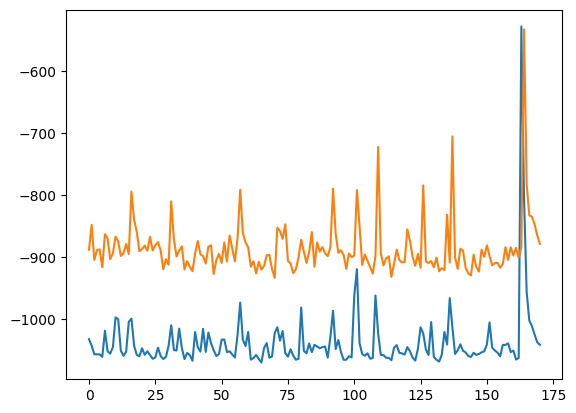

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-28 11:52:56.848480


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3
predict diverge [-30.52584221 -27.09828567  19.13173325 -17.56315186] [-0.94742459 -9.18448017 -0.97921112  1.23031433] [ 91.917595  20.42253  126.01955   29.298172] [45.958797 10.211265 63.009773 14.649086] sim_timestep 120

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23
predict diverge [-46.97067927 -23.98569127  35.91661205 -34.62993472] [ -0.48479267 -14.59151317  -0.96393194 -11.87981997] [ 91.917595  20.42253  126.01955   29.298172] [45.958797 10.211265 63.009773 14.649086] sim_timestep 139

 24
predict diverge [ -2.06986858 -24.14191313  16.34280005  18.15273097] [-1.00716083 -4.50064875  0.82389977  0.63455935] [ 91.917595  20.42253  126.01955   29.298172] [45.958797 10.211265 63.009773 14.649086] sim_timestep 43

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 

In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.51974  validloss 0.62322±0.00000  bestvalidloss 0.62322  last_update 0
train: iter 1  trainloss 0.49979  validloss 0.56102±0.00000  bestvalidloss 0.56102  last_update 0
train: iter 2  trainloss 0.49036  validloss 0.54240±0.00000  bestvalidloss 0.54240  last_update 0
train: iter 3  trainloss 0.48698  validloss 0.53028±0.00000  bestvalidloss 0.53028  last_update 0
train: iter 4  trainloss 0.48218  validloss 0.53168±0.00000  bestvalidloss 0.53028  last_update 1
train: iter 5  trainloss 0.47974  validloss 0.53817±0.00000  bestvalidloss 0.53028  last_update 2
train: iter 6  trainloss 0.47277  validloss 0.53830±0.00000  bestvalidloss 0.53028  last_update 3
train: iter 7  trainloss 0.47405  validloss 0.51839±0.00000  bestvalidloss 0.51839  last_update 0
train: iter 8  trainloss 0.47510  validloss 0.53784±0.00000  bestvalidloss 0.51839  last_update 1
train: iter 9  trainloss 0.47233  validloss 0.53127±0.00000  bestvalidloss 0.51839  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.43500  validloss 0.53703±0.00000  bestvalidloss 0.50776  last_update 38
train: iter 84  trainloss 0.44155  validloss 0.54336±0.00000  bestvalidloss 0.50776  last_update 39
train: iter 85  trainloss 0.44100  validloss 0.52034±0.00000  bestvalidloss 0.50776  last_update 40
train: iter 86  trainloss 0.43790  validloss 0.53570±0.00000  bestvalidloss 0.50776  last_update 41
train: iter 87  trainloss 0.44063  validloss 0.52692±0.00000  bestvalidloss 0.50776  last_update 42
train: iter 88  trainloss 0.43870  validloss 0.52053±0.00000  bestvalidloss 0.50776  last_update 43
train: iter 89  trainloss 0.43748  validloss 0.51901±0.00000  bestvalidloss 0.50776  last_update 44
train: iter 90  trainloss 0.44324  validloss 0.53807±0.00000  bestvalidloss 0.50776  last_update 45
train: iter 91  trainloss 0.43509  validloss 0.54556±0.00000  bestvalidloss 0.50776  last_update 46
train: iter 92  trainloss 0.43486  validloss 0.54780±0.00000  bestvalidloss 0.50776  last_update 47


([0.5197408061474562,
  0.4997886257246137,
  0.4903587820008397,
  0.4869759131222963,
  0.48217869400978086,
  0.479744840040803,
  0.47276684511452916,
  0.474054011516273,
  0.47510364577174186,
  0.4723257251083851,
  0.46661983970552684,
  0.46886469069868325,
  0.4697887856513262,
  0.4636450335383415,
  0.4637123040854931,
  0.4632159635424614,
  0.46319728083908557,
  0.45979989785701036,
  0.46402322184294464,
  0.45774071104824543,
  0.4616282472386956,
  0.4593950714915991,
  0.45972324777394535,
  0.4582166150212288,
  0.45697695594280957,
  0.45156002771109344,
  0.45872456058859823,
  0.453619390539825,
  0.4571242582052946,
  0.4582554504275322,
  0.4551642956212163,
  0.4535312639549375,
  0.4536914939060807,
  0.45497155375778675,
  0.4555918872356415,
  0.4509285088628531,
  0.45454390477389095,
  0.4584390355274081,
  0.4535851713269949,
  0.45152565035969017,
  0.4486407920718193,
  0.45171707179397347,
  0.44951208755373956,
  0.45104011353105306,
  0.454383170977

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.429133539754153
valid_loss:  -7.642759463691712
weight_alpha 1.0 h_min_tilde -11.723216 ell_tilde -5.8718587245416645 kappa_tilde 0.00041340115887053596
train_loss:  -5.098470257669687
valid_loss:  -4.295404885101318
weight_alpha 0.1 h_min_tilde -11.723216 ell_tilde -4.937857183156013 kappa_tilde 0.0003838960016733971


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 986.22224  validloss 1076.78599±0.00000  bestvalidloss 1076.78599  last_update 0
train: iter 1  trainloss 845.44817  validloss 917.73867±0.00000  bestvalidloss 917.73867  last_update 0
train: iter 2  trainloss 734.34394  validloss 783.51113±0.00000  bestvalidloss 783.51113  last_update 0
train: iter 3  trainloss 636.95516  validloss 687.30178±0.00000  bestvalidloss 687.30178  last_update 0
train: iter 4  trainloss 560.90290  validloss 599.07897±0.00000  bestvalidloss 599.07897  last_update 0
train: iter 5  trainloss 491.34356  validloss 518.57457±0.00000  bestvalidloss 518.57457  last_update 0
train: iter 6  trainloss 433.09632  validloss 459.45359±0.00000  bestvalidloss 459.45359  last_update 0
train: iter 7  trainloss 384.10292  validloss 401.34312±0.00000  bestvalidloss 401.34312  last_update 0
train: iter 8  trainloss 339.81664  validloss 360.60427±0.00000  bestvalidloss 360.60427  last_update 0
train: iter 9  trainloss 303.60792  validloss 322.63549±0.0000

train: iter 84  trainloss 5.95737  validloss 2.63449±0.00000  bestvalidloss 2.61986  last_update 1
train: iter 85  trainloss 5.75423  validloss 2.66437±0.00000  bestvalidloss 2.61986  last_update 2
train: iter 86  trainloss 5.68988  validloss 2.55551±0.00000  bestvalidloss 2.55551  last_update 0
train: iter 87  trainloss 5.57869  validloss 2.55714±0.00000  bestvalidloss 2.55551  last_update 1
train: iter 88  trainloss 5.36275  validloss 2.54001±0.00000  bestvalidloss 2.54001  last_update 0
train: iter 89  trainloss 5.33530  validloss 2.40729±0.00000  bestvalidloss 2.40729  last_update 0
train: iter 90  trainloss 5.28107  validloss 2.54049±0.00000  bestvalidloss 2.40729  last_update 1
train: iter 91  trainloss 5.07754  validloss 2.27092±0.00000  bestvalidloss 2.27092  last_update 0
train: iter 92  trainloss 5.08650  validloss 2.01286±0.00000  bestvalidloss 2.01286  last_update 0
train: iter 93  trainloss 4.84687  validloss 2.19167±0.00000  bestvalidloss 2.01286  last_update 1
train: ite

train: iter 167  trainloss 1.16962  validloss 0.45622±0.00000  bestvalidloss 0.44891  last_update 2
train: iter 168  trainloss 1.16493  validloss 0.48190±0.00000  bestvalidloss 0.44891  last_update 3
train: iter 169  trainloss 1.14068  validloss 0.50658±0.00000  bestvalidloss 0.44891  last_update 4
train: iter 170  trainloss 1.11680  validloss 0.45209±0.00000  bestvalidloss 0.44891  last_update 5
train: iter 171  trainloss 1.11979  validloss 0.53767±0.00000  bestvalidloss 0.44891  last_update 6
train: iter 172  trainloss 1.09748  validloss 0.48399±0.00000  bestvalidloss 0.44891  last_update 7
train: iter 173  trainloss 1.10265  validloss 0.47783±0.00000  bestvalidloss 0.44891  last_update 8
train: iter 174  trainloss 1.09351  validloss 0.51099±0.00000  bestvalidloss 0.44891  last_update 9
train: iter 175  trainloss 1.10130  validloss 0.45205±0.00000  bestvalidloss 0.44891  last_update 10
train: iter 176  trainloss 1.08419  validloss 0.46439±0.00000  bestvalidloss 0.44891  last_update 1

train: iter 254  trainloss 0.98789  validloss 0.54105±0.00000  bestvalidloss 0.44891  last_update 89
train: iter 255  trainloss 0.99318  validloss 0.54488±0.00000  bestvalidloss 0.44891  last_update 90
train: iter 256  trainloss 0.98386  validloss 0.53438±0.00000  bestvalidloss 0.44891  last_update 91
train: iter 257  trainloss 0.99265  validloss 0.53614±0.00000  bestvalidloss 0.44891  last_update 92
train: iter 258  trainloss 0.98801  validloss 0.53388±0.00000  bestvalidloss 0.44891  last_update 93
train: iter 259  trainloss 0.99024  validloss 0.53093±0.00000  bestvalidloss 0.44891  last_update 94
train: iter 260  trainloss 0.99387  validloss 0.51490±0.00000  bestvalidloss 0.44891  last_update 95
train: iter 261  trainloss 0.98991  validloss 0.52994±0.00000  bestvalidloss 0.44891  last_update 96
train: iter 262  trainloss 0.99306  validloss 0.53763±0.00000  bestvalidloss 0.44891  last_update 97
train: iter 263  trainloss 0.98587  validloss 0.53282±0.00000  bestvalidloss 0.44891  last_

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.0437, -1.7456, -1.6167, -2.8540], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 8.42078  validloss 12.73494±0.00000  bestvalidloss 12.73494  last_update 0
train: iter 1  trainloss 7.53109  validloss 14.31612±0.00000  bestvalidloss 12.73494  last_update 1
train: iter 2  trainloss 7.20672  validloss 14.13559±0.00000  bestvalidloss 12.73494  last_update 2
train: iter 3  trainloss 7.08731  validloss 13.97258±0.00000  bestvalidloss 12.73494  last_update 3
train: iter 4  trainloss 6.97363  validloss 13.92065±0.00000  bestvalidloss 12.73494  last_update 4
train: iter 5  trainloss 6.84300  validloss 13.61837±0.00000  bestvalidloss 12.73494  last_update 5
train: iter 6  trainloss 6.80796  validloss 13.53774±0.00000  bestvalidloss 12.73494  last_update 6
train: iter 7  trainloss 6.77654  validloss 13.63590±0.00000  bestvalidloss 12.73494  last_update 7
train: iter 8  trainloss 6.73328  validloss 13.23444±0.00000  bestvalidloss 12.73494  last_update 8
train: iter 9  trainloss 6.72512  validloss 13.06378±0.00000  bestvalidloss 12.73494  last_update 9


train: iter 81  trainloss 5.98954  validloss 13.20891±0.00000  bestvalidloss 12.08501  last_update 20
train: iter 82  trainloss 6.01752  validloss 12.85352±0.00000  bestvalidloss 12.08501  last_update 21
train: iter 83  trainloss 5.95097  validloss 12.96306±0.00000  bestvalidloss 12.08501  last_update 22
train: iter 84  trainloss 6.02654  validloss 12.78980±0.00000  bestvalidloss 12.08501  last_update 23
train: iter 85  trainloss 5.92636  validloss 12.51701±0.00000  bestvalidloss 12.08501  last_update 24
train: iter 86  trainloss 5.88904  validloss 12.96517±0.00000  bestvalidloss 12.08501  last_update 25
train: iter 87  trainloss 5.94259  validloss 12.79173±0.00000  bestvalidloss 12.08501  last_update 26
train: iter 88  trainloss 6.02030  validloss 12.17878±0.00000  bestvalidloss 12.08501  last_update 27
train: iter 89  trainloss 5.93864  validloss 12.58701±0.00000  bestvalidloss 12.08501  last_update 28
train: iter 90  trainloss 5.92037  validloss 12.57119±0.00000  bestvalidloss 12.08

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-7.2600)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(15.5986)


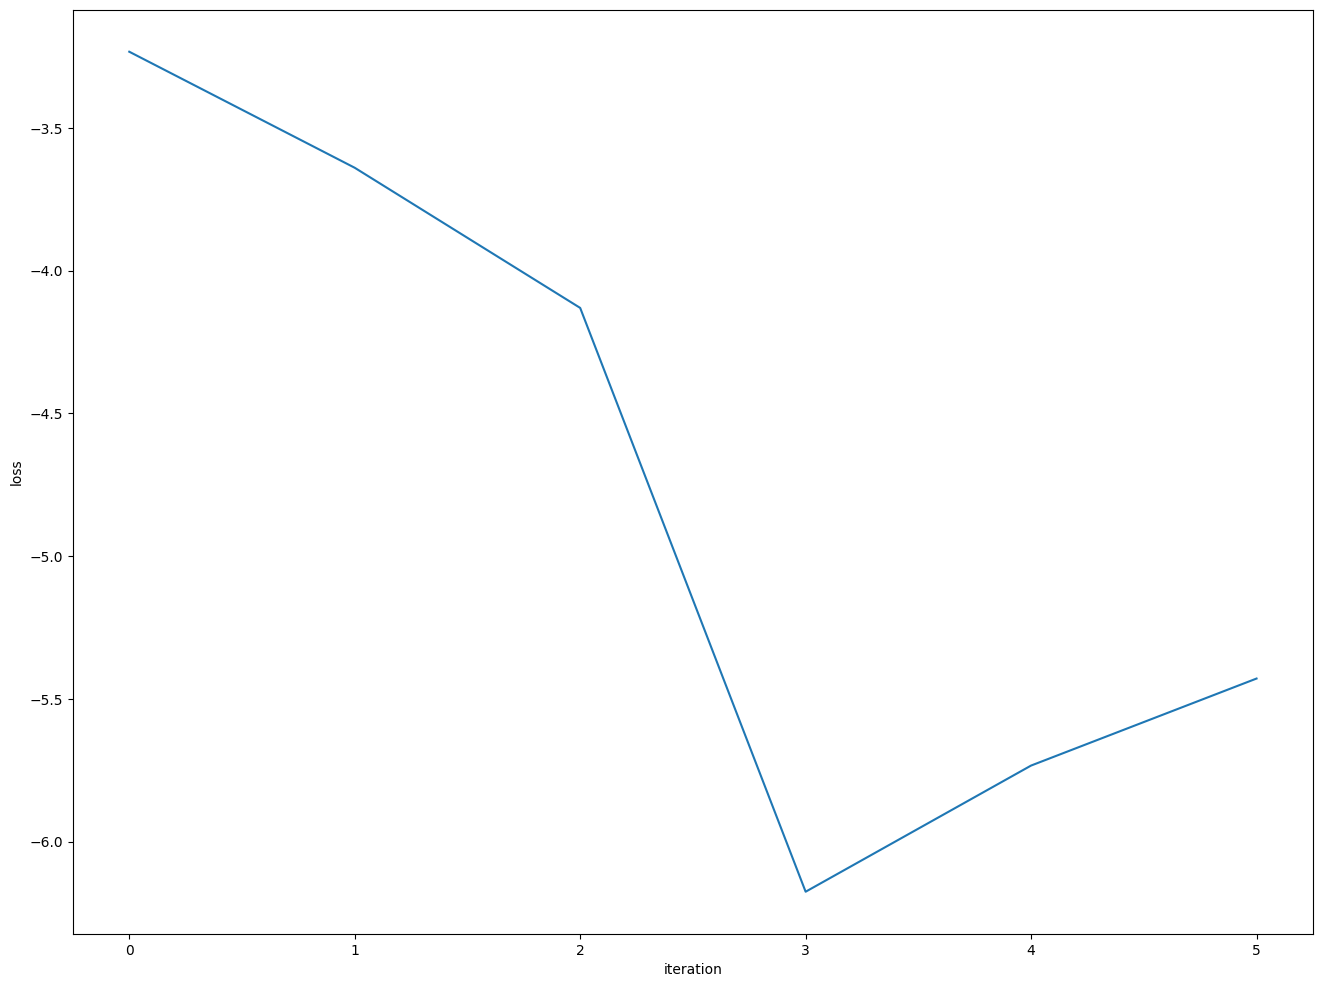

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

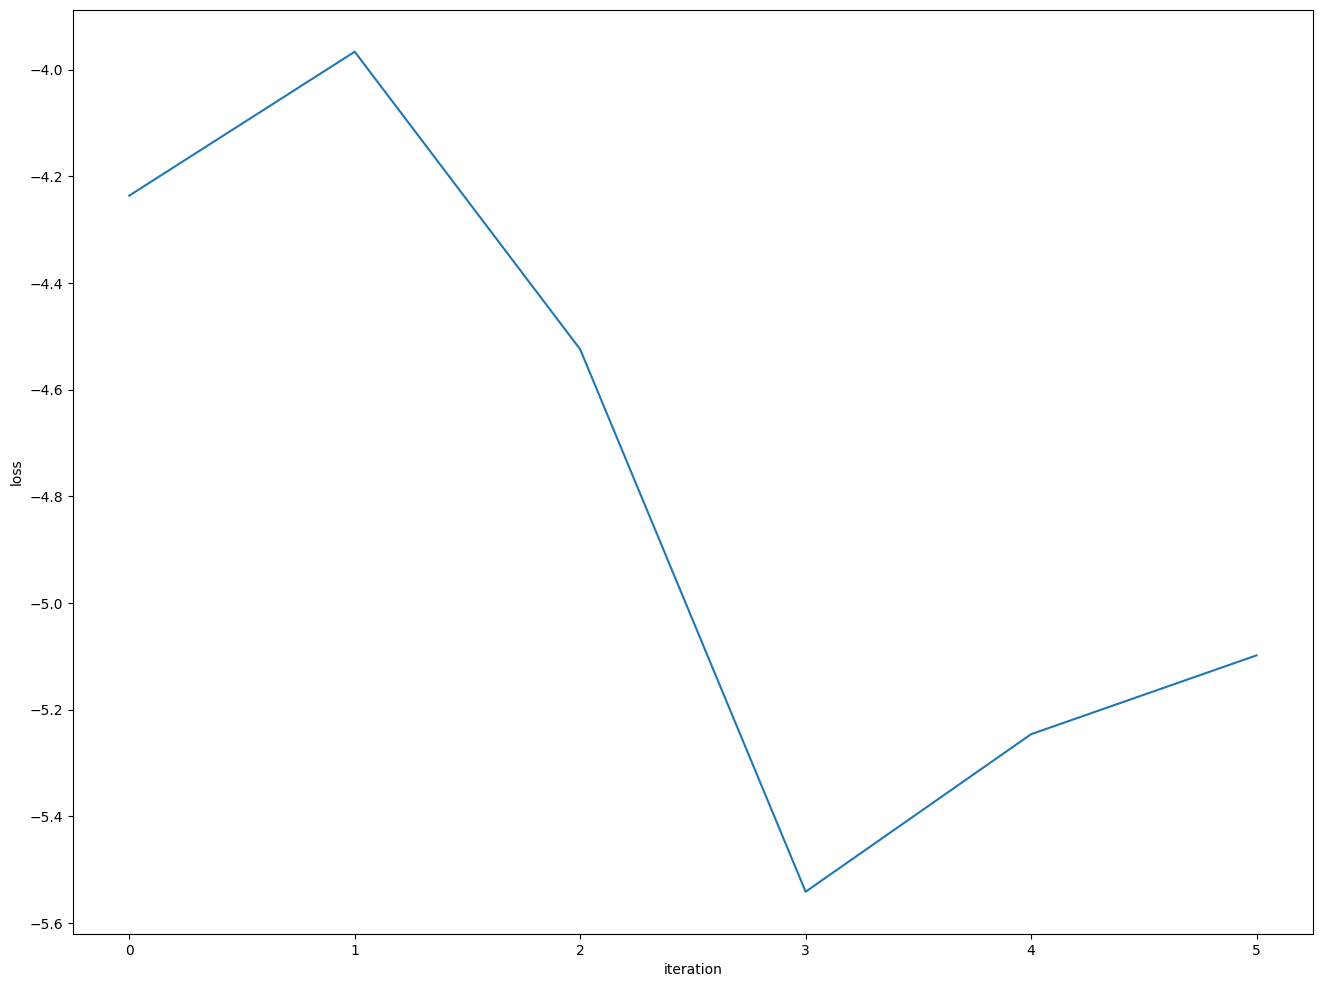

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")